# Load libraries

In [2]:
import json 
import pandas as pd
import numpy as np
import time
import ollama
import regex as re
import ast
import random
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, fbeta_score
from sklearn.metrics import classification_report
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics import cohen_kappa_score

# Training data

In [4]:
with open('rob_dataset_train.json', 'r') as f:
    data = json.load(f)

Let's create data frame. 

In [6]:
df = pd.DataFrame(data)

In [7]:
df.head()

,id,review,study,question,context,answers,label,bias,bias_id,filename,line,context_tokens,answer_tokens
0,661811223c6e44b26b18c624,CD000011,STD-Apter-2011,Was the allocation sequence random?,procedures questionnaires on socio-demographic...,"{'text': ['two weeks later (visit 2), subjects...",LOW,Random sequence generation (selection bias),QIT-01,PMC3164914.txt,50,210,32
1,661811223c6e44b26b18dddc,CD000011,STD-Apter-2011,Was the allocation sequence concealed until pa...,procedures questionnaires on socio-demographic...,"{'text': ['two weeks later (visit 2), subjects...",UNCLEAR,Allocation concealment (selection bias),QIT-02,PMC3164914.txt,50,210,32
2,6682e732cb7deacf322d45ff,CD000011,STD-Apter-2011,Incomplete outcome data addressed?,table e-1 describes the barriers to adherence ...,{'text': ['monitor downloads failed in 380 (20...,HIGH,Incomplete outcome data (attrition bias),QIT-04,PMC3164914.txt,135,163,26
3,6682e732cb7deacf322d4601,CD000011,STD-Apter-2011,Incomplete outcome data addressed?,"failures were attributed to monitor failure, b...",{'text': ['asthma control measured by the asth...,UNCLEAR,Incomplete outcome data (attrition bias),QIT-04,PMC3164914.txt,139,217,48
4,6682ee8655ab5b35a774dc8f,CD000011,STD-Apter-2011,Free from other types of bias?,some support for this argument comes from tabl...,{'text': ['the limitations of our study are in...,HIGH,Other bias,QIT-06,PMC3164914.txt,172,143,10


Get unique Cochrane reviews. 

In [9]:
len(pd.unique(df['review']))

1847

Finding Jill's review. 

In [11]:
if "CD009790" in pd.unique(df['review']):
    print("CD009790")

CD009790


In [12]:
df[df['review'] == "CD009790"]

,id,review,study,question,context,answers,label,bias,bias_id,filename,line,context_tokens,answer_tokens
7052,661811223c6e44b26b18fcec,CD009790,STD-Akhtar-2017,"Were the trial participants, staff, and study ...",data collection method: patient’s basic demogr...,{'text': ['subjects were randomly allocated to...,LOW,Blinding of participants and personnel (perfor...,QIT-03,PMC5648929.txt,42,154,29
7053,661811223c6e44b26b18d1f8,CD009790,STD-Akhtar-2017,Was the allocation sequence random?,data collection method: patient’s basic demogr...,{'text': ['subjects were randomly allocated to...,LOW,Random sequence generation (selection bias),QIT-01,PMC5648929.txt,42,154,29
7054,661811223c6e44b26b18e817,CD009790,STD-Bhadauria-2017,Was the allocation sequence concealed until pa...,the sample size was determined by preliminary ...,{'text': ['forty-four subjects were assessed a...,LOW,Allocation concealment (selection bias),QIT-02,PMC5667628.txt,46,205,21
7055,661811223c6e44b26b18d1fa,CD009790,STD-Bramberg-2017,Was the allocation sequence random?,the study is registered in the clinical trials...,{'text': ['a random allocation sequence was ge...,UNCLEAR,Random sequence generation (selection bias),QIT-01,PMC5372262.txt,45,108,16
7056,661811223c6e44b26b18fcef,CD009790,STD-Bramberg-2017,"Were the trial participants, staff, and study ...",the study used a block randomization design. a...,{'text': ['the participants did not know the c...,LOW,Blinding of participants and personnel (perfor...,QIT-03,PMC5372262.txt,47,116,15
7057,661811223c6e44b26b18fcee,CD009790,STD-Bramberg-2017,"Were the trial participants, staff, and study ...",a random allocation sequence was generated by ...,{'text': ['the yoga leader and physiotherapist...,LOW,Blinding of participants and personnel (perfor...,QIT-03,PMC5372262.txt,48,136,13
7058,661811223c6e44b26b18e819,CD009790,STD-Chung-2018,Was the allocation sequence concealed until pa...,they observed that the thickness of the tra in...,{'text': ['the main limitation of the present ...,HIGH,Allocation concealment (selection bias),QIT-02,PMC5857446.txt,89,199,25
7059,661811223c6e44b26b18e81a,CD009790,STD-Groessl-2017,Was the allocation sequence concealed until pa...,inclusion and exclusion criteria for the study...,{'text': ['after the baseline assessment was c...,LOW,Allocation concealment (selection bias),QIT-02,PMC6399016.txt,43,269,38
7060,661811223c6e44b26b18d1fc,CD009790,STD-Hasanpour_x002d_Dehkordi-2017,Was the allocation sequence random?,materials and methods this randomized clinical...,{'text': ['the first case was selected using r...,UNCLEAR,Random sequence generation (selection bias),QIT-01,PMC5294435.txt,50,141,22
7061,661811223c6e44b26b18d1fd,CD009790,STD-Helmhout-2004,Was the allocation sequence random?,"at the third visit, patients are randomized in...",{'text': ['randomization is done by means of a...,LOW,Random sequence generation (selection bias),QIT-01,PMC533884.txt,90,181,28


Look at answers.

In [14]:
answers_text = []
answers_start = []
for i in df['answers']:
    answers_text.append(i['text'][0])
    answers_start.append(i['answer_start'][0])

In [15]:
len(answers_text)
# answers_text

13554

In [16]:
len(answers_start)
# answers_start

13554

In [17]:
df['answers_text'] = answers_text

In [18]:
df['answers_start'] = answers_start

In [19]:
df.drop('answers', inplace = True, axis = 1)

In [20]:
df

,id,review,study,question,context,label,bias,bias_id,filename,line,context_tokens,answer_tokens,answers_text,answers_start
0,661811223c6e44b26b18c624,CD000011,STD-Apter-2011,Was the allocation sequence random?,procedures questionnaires on socio-demographic...,LOW,Random sequence generation (selection bias),QIT-01,PMC3164914.txt,50,210,32,"two weeks later (visit 2), subjects were rando...",473
1,661811223c6e44b26b18dddc,CD000011,STD-Apter-2011,Was the allocation sequence concealed until pa...,procedures questionnaires on socio-demographic...,UNCLEAR,Allocation concealment (selection bias),QIT-02,PMC3164914.txt,50,210,32,"two weeks later (visit 2), subjects were rando...",473
2,6682e732cb7deacf322d45ff,CD000011,STD-Apter-2011,Incomplete outcome data addressed?,table e-1 describes the barriers to adherence ...,HIGH,Incomplete outcome data (attrition bias),QIT-04,PMC3164914.txt,135,163,26,monitor downloads failed in 380 (20%) of 2360 ...,278
3,6682e732cb7deacf322d4601,CD000011,STD-Apter-2011,Incomplete outcome data addressed?,"failures were attributed to monitor failure, b...",UNCLEAR,Incomplete outcome data (attrition bias),QIT-04,PMC3164914.txt,139,217,48,asthma control measured by the asthma control ...,332
4,6682ee8655ab5b35a774dc8f,CD000011,STD-Apter-2011,Free from other types of bias?,some support for this argument comes from tabl...,HIGH,Other bias,QIT-06,PMC3164914.txt,172,143,10,the limitations of our study are informative.,453
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13549,661811223c6e44b26b18f286,CD015391,STD-TOGETHER-2021,Was the allocation sequence concealed until pa...,in the together trial for acutely symptomatic ...,LOW,Bias due to deviations from intended intervent...,QIT-02,PMC8550952.txt,11,271,17,"the trial team, site staff, and patients were ...",699
13550,661811223c6e44b26b18ddd7,CD015391,STD-TOGETHER-2021,Was the allocation sequence random?,after obtaining informed consent a rapid antig...,LOW,Bias arising from the randomization process,QIT-01,PMC8550952.txt,59,231,48,randomisation and masking participants were r...,615
13551,661811223c6e44b26b18ddd8,CD015391,STD-TOGETHER-2021,Was the allocation sequence random?,randomisation and masking participants were r...,LOW,Bias arising from the randomization process,QIT-01,PMC8550952.txt,62,174,37,patients were randomly assigned (1:1) by means...,396
13552,661811223c6e44b26b18f287,CD015391,STD-TOGETHER-2021,Was the allocation sequence concealed until pa...,this maintained concealment of allocation. pat...,LOW,Bias due to deviations from intended intervent...,QIT-02,PMC8550952.txt,64,176,30,the active drugs and the placebo pills were pa...,276


We have 4,329 studies across 1,847 reviews in this training set. 

In [22]:
df.describe(include='all')

,id,review,study,question,context,label,bias,bias_id,filename,line,context_tokens,answer_tokens,answers_text,answers_start
count,13554,13554,13554,13554,13554,13554,13554,13554,13554,13554.000000,13554.000000,13554.000000,13554,13554.000000
unique,13554,1847,4329,7,11093,3,123,23,4428,NaN,NaN,NaN,11072,NaN
top,661811223c6e44b26b18c624,CD000011,STD-Heisler-2010,Was the allocation sequence random?,all participants or their surrogates gave writ...,LOW,Random sequence generation (selection bias),QIT-01,PMC1995577.txt,NaN,NaN,NaN,randomization schedules were generated by pers...,NaN
freq,1,207,28,4047,7,9146,3900,4047,34,NaN,NaN,NaN,7,NaN
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,67.672495,250.334735,34.930353,NaN,521.858271
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,51.045278,145.870885,25.642618,NaN,251.102459
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,70.000000,6.000000,NaN,0.000000
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,38.000000,188.000000,21.000000,NaN,370.000000
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,54.000000,225.000000,30.000000,NaN,471.000000
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,82.000000,279.000000,41.000000,NaN,606.000000


### Let's better understand how question, bias, and bias_id relate to one another. 

In [24]:
df_short = df[['question', 'bias', 'bias_id']]

In [25]:
df_short

,question,bias,bias_id
0,Was the allocation sequence random?,Random sequence generation (selection bias),QIT-01
1,Was the allocation sequence concealed until pa...,Allocation concealment (selection bias),QIT-02
2,Incomplete outcome data addressed?,Incomplete outcome data (attrition bias),QIT-04
3,Incomplete outcome data addressed?,Incomplete outcome data (attrition bias),QIT-04
4,Free from other types of bias?,Other bias,QIT-06
...,...,...,...
13549,Was the allocation sequence concealed until pa...,Bias due to deviations from intended intervent...,QIT-02
13550,Was the allocation sequence random?,Bias arising from the randomization process,QIT-01
13551,Was the allocation sequence random?,Bias arising from the randomization process,QIT-01
13552,Was the allocation sequence concealed until pa...,Bias due to deviations from intended intervent...,QIT-02


In [26]:
df_biases = df_short.groupby('question').agg(pd.unique)
df_biases

,bias,bias_id
question,,
Free from other types of bias?,"[Other bias, Free of other bias?, Free of othe...","[QIT-06, QIT-09, QIT-07, QIT-11, QIT-13, QIT-1..."
Free of selective reporting?,"[Selective reporting (reporting bias), Free of...","[QIT-05, QIT-06, QIT-16, QIT-17, QIT-22, QIT-0..."
Incomplete outcome data addressed?,"[Incomplete outcome data (attrition bias), Inc...","[QIT-04, QIT-08, QIT-12, QIT-05, QIT-07, QIT-1..."
Was the allocation sequence concealed until participants were enrolled and assigned to interventions?,"[Allocation concealment (selection bias), Allo...",[QIT-02]
Was the allocation sequence random?,"[Random sequence generation (selection bias), ...",[QIT-01]
Was the outcome assessor blinded to the intervention?,[Blinding of outcome assessment (detection bia...,"[QIT-08, QIT-10, QIT-09, QIT-12, QIT-15, QIT-1..."
"Were the trial participants, staff, and study personnel blind to the intervention?","[Blinding of participants (performance bias), ...","[QIT-09, QIT-10, QIT-07, QIT-08, QIT-11, QIT-1..."


In [27]:
df_biases.reset_index(inplace = True)

### Free from other types of bias?

In [29]:
df_biases['bias'][0]

array(['Other bias', 'Free of other bias?',
       'Free of other bias? Comparability of the groups',
       'Other bias- timing of recruitment of clusters',
       'Free of other bias', 'Other bias - ITS',
       'Other bias - treatment manual',
       'Other bias #2 - Consistency in intervention delivery',
       'Other bias #1 - Baseline comparability of participant characteristics between groups',
       'Other bias: equivalence of baseline characteristics (selection bias)',
       'Other Bias: Baseline characteristics similarity',
       'Other Bias: Contamination',
       'Other bias (additional SWL sessions)',
       'Risk of contamination (other bias)'], dtype=object)

In [30]:
print(len(df_biases['bias'][0])); len(df_biases['bias_id'][0])

14


10

### Free of selective reporting?	

In [32]:
df_biases['bias'][1]

array(['Selective reporting (reporting bias)',
       'Free of selective reporting?',
       'Free of selected reporting (ITS) ?',
       'Selective reporting (reporting bias) - ITS',
       'Selective outcome reporting (reporting bias)',
       'Selective outcome reporting', 'Reporting bias',
       'Selective recruitment of participants (cluster-RCTs)',
       'Selective recruitment of participants (cluster RCTs)',
       'Selective reporting', 'Well-defined outcome (reporting bias)',
       'Well-defined follow-up (reporting bias)',
       'Well-defined outcome severe fatigue (reporting bias)',
       'Selective cluster recruitment'], dtype=object)

In [33]:
print(len(df_biases['bias'][1])); len(df_biases['bias_id'][1])

14


12

### Incomplete outcome data addressed?

In [35]:
df_biases['bias'][2]

array(['Incomplete outcome data (attrition bias)',
       'Incomplete outcome data addressed?',
       'Incomplete outcome data? (Caries efficacy outcomes)',
       'Incomplete outcome data (attrition and exclusions)',
       'Incomplete outcome data', 'Incomplete outcome data?',
       'Incomplete outcome data addressed (ITS) ?',
       'Incomplete outcome data (attrition bias): Mortality',
       'Incomplete outcome assessment',
       'Incomplete outcome data addressed? (Post-treatment)',
       'Incomplete outcome data (Adverse Events)',
       'Were incomplete outcome data adequately addressed?',
       '4) Attrition bias (incomplete outcome data)'], dtype=object)

In [36]:
print(len(df_biases['bias'][2])); len(df_biases['bias_id'][2])

13


10

### Was the allocation sequence concealed until participants were enrolled and assigned to interventions?

**'Bias due to deviations from intended interventions' is from RoB2**

In [38]:
df_biases['bias'][3]

array(['Allocation concealment (selection bias)',
       'Allocation concealment?',
       'Bias due to deviations from intended interventions'], dtype=object)

In [39]:
print(len(df_biases['bias'][3])); len(df_biases['bias_id'][3])

3


1

### Was the allocation sequence random?

**'Bias arising from the randomization process' is from RoB2**

In [41]:
df_biases['bias'][4]

array(['Random sequence generation (selection bias)',
       'Adequate sequence generation?',
       'Bias arising from the randomization process',
       'Adequate sequence generation'], dtype=object)

In [42]:
print(len(df_biases['bias'][4])); len(df_biases['bias_id'][4])

4


1

### Was the outcome assessor blinded to the intervention?

**'Complete outcome assessment/follow-up (attrition bias)' and  'Incomplete outcome assessment'** are attrition bias, not detection bias. 

In [45]:
df_biases['bias'][5]

array(['Blinding of outcome assessment (detection bias)',
       'Blinding of outcome assessment',
       'Blinding of outcome assessment (detection bias) (Process variables)',
       'Blinding of outcome assessment (detection bias) (Patient satisfaction, health status).',
       'Blinding of outcome assessor (detection bias)',
       'Blinding of outcome assessment (detection bias) (outcomes other than overall survival and quality of life)',
       'Incomplete outcome assessment',
       'Blinding of microbiological outcome (detection bias)',
       'Blinding of outcome assessment - DFS & Toxicity (detection bias)',
       'Blinding of outcome assessors for other outcomes (detection bias)',
       'Blinding of outcome assessors for mortality (detection bias)',
       'Masking of outcome assessors (detection bias)',
       'Masking of outcome assessment (detection bias)',
       'Blinding of outcome assessment for outcome assessor reported outcomes (detection bias)',
       'Blinding o

In [46]:
print(len(df_biases['bias'][5])); len(df_biases['bias_id'][5])

46


14

### Were the trial participants, staff, and study personnel blind to the intervention?

In [48]:
df_biases['bias'][6]

array(['Blinding of participants (performance bias)',
       'Blinding of personnel (performance bias)',
       'Blinding of participants and personnel (performance bias)',
       'Blinding of participants and personnel (performance bias): mortality',
       'Blinding of participants and personnel (performance bias): transfusion/renal replacement therapy/adverse events',
       'Blinding of participants and personnel', 'Blinding of personnel',
       'Blinding of participants',
       'Blinding of participants ((semi)objective outcomes)',
       'Blinding of participants/personnel (efficacy outcomes);performance bias',
       'Masking of participants (performance bias)',
       'Masking of study personnel (performance bias)',
       'Blinding of participants?',
       '3a) Performance bias (blinding of personnel)',
       'Masking of participants and personnel of the allocated intervention during the study (performance bias)',
       'Adequate blinding of participants?',
       'Blindi

In [49]:
print(len(df_biases['bias'][6])); len(df_biases['bias_id'][6])

31


13

### RoB2 Qs

Let's find out how many RoB2 questions may be in there. One question I have: why would there be questions for two of the five RoB2 domains? In other words, am I missing some other RoB2 domains, or were those taken care of in data cleaning process?

In [52]:
RoB2_idx = (df['bias'] == 'Bias arising from the randomization process') | (df['bias'] == 'Bias due to deviations from intended interventions')
RoB2_idx

0        False
1        False
2        False
3        False
4        False
         ...  
13549     True
13550     True
13551     True
13552     True
13553     True
Name: bias, Length: 13554, dtype: bool

Let's look at the data frame. Why are there duplicates? Perhaps because of review updates. Anyway, **review updates explain why older Cochrane review IDs have RoB2 questions. Indeed, I confirmed that the 2022 update of CD002990 used RoB2.**

In [54]:
df[RoB2_idx]

,id,review,study,question,context,label,bias,bias_id,filename,line,context_tokens,answer_tokens,answers_text,answers_start
1587,661811223c6e44b26b18c8d4,CD002990,STD-Bischoff-2012,Was the allocation sequence random?,interventions a comprehensive self management ...,UNCLEAR,Bias arising from the randomization process,QIT-01,PMC3514071.txt,9,275,31,results 165 patients were allocated to self ma...,812
1588,661811223c6e44b26b18c8d2,CD002990,STD-Bischoff-2012,Was the allocation sequence random?,the investigators randomised the order in whic...,UNCLEAR,Bias arising from the randomization process,QIT-01,PMC3514071.txt,30,336,65,randomisation and interventions we randomised ...,848
1589,661811223c6e44b26b18dfdf,CD002990,STD-Bischoff-2012,Was the allocation sequence concealed until pa...,patients were eligible for the study if they w...,HIGH,Bias due to deviations from intended intervent...,QIT-02,PMC3514071.txt,32,326,51,we prevented potential treatment contamination...,1007
1590,661811223c6e44b26b18dfdb,CD002990,STD-Bischoff-2012,Was the allocation sequence concealed until pa...,patients answered (yes or no) to questions fro...,HIGH,Bias due to deviations from intended intervent...,QIT-02,PMC3514071.txt,65,327,22,our primary analysis was based on the intentio...,1191
1591,661811223c6e44b26b18dfdc,CD002990,STD-Bischoff-2012,Was the allocation sequence concealed until pa...,texas was not part of any intervention and did...,HIGH,Bias due to deviations from intended intervent...,QIT-02,PMC3514071.txt,66,325,16,we compared self management with usual care an...,1017
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13549,661811223c6e44b26b18f286,CD015391,STD-TOGETHER-2021,Was the allocation sequence concealed until pa...,in the together trial for acutely symptomatic ...,LOW,Bias due to deviations from intended intervent...,QIT-02,PMC8550952.txt,11,271,17,"the trial team, site staff, and patients were ...",699
13550,661811223c6e44b26b18ddd7,CD015391,STD-TOGETHER-2021,Was the allocation sequence random?,after obtaining informed consent a rapid antig...,LOW,Bias arising from the randomization process,QIT-01,PMC8550952.txt,59,231,48,randomisation and masking participants were r...,615
13551,661811223c6e44b26b18ddd8,CD015391,STD-TOGETHER-2021,Was the allocation sequence random?,randomisation and masking participants were r...,LOW,Bias arising from the randomization process,QIT-01,PMC8550952.txt,62,174,37,patients were randomly assigned (1:1) by means...,396
13552,661811223c6e44b26b18f287,CD015391,STD-TOGETHER-2021,Was the allocation sequence concealed until pa...,this maintained concealment of allocation. pat...,LOW,Bias due to deviations from intended intervent...,QIT-02,PMC8550952.txt,64,176,30,the active drugs and the placebo pills were pa...,276


Let's focus on **CD002990**. It does not look like there are any other bias domains. 

In [56]:
df[df['review'] == "CD002990"]

,id,review,study,question,context,label,bias,bias_id,filename,line,context_tokens,answer_tokens,answers_text,answers_start
1587,661811223c6e44b26b18c8d4,CD002990,STD-Bischoff-2012,Was the allocation sequence random?,interventions a comprehensive self management ...,UNCLEAR,Bias arising from the randomization process,QIT-01,PMC3514071.txt,9,275,31,results 165 patients were allocated to self ma...,812
1588,661811223c6e44b26b18c8d2,CD002990,STD-Bischoff-2012,Was the allocation sequence random?,the investigators randomised the order in whic...,UNCLEAR,Bias arising from the randomization process,QIT-01,PMC3514071.txt,30,336,65,randomisation and interventions we randomised ...,848
1589,661811223c6e44b26b18dfdf,CD002990,STD-Bischoff-2012,Was the allocation sequence concealed until pa...,patients were eligible for the study if they w...,HIGH,Bias due to deviations from intended intervent...,QIT-02,PMC3514071.txt,32,326,51,we prevented potential treatment contamination...,1007
1590,661811223c6e44b26b18dfdb,CD002990,STD-Bischoff-2012,Was the allocation sequence concealed until pa...,patients answered (yes or no) to questions fro...,HIGH,Bias due to deviations from intended intervent...,QIT-02,PMC3514071.txt,65,327,22,our primary analysis was based on the intentio...,1191
1591,661811223c6e44b26b18dfdc,CD002990,STD-Bischoff-2012,Was the allocation sequence concealed until pa...,texas was not part of any intervention and did...,HIGH,Bias due to deviations from intended intervent...,QIT-02,PMC3514071.txt,66,325,16,we compared self management with usual care an...,1017
1592,661811223c6e44b26b18dfe0,CD002990,STD-Bischoff-2012,Was the allocation sequence concealed until pa...,more patients in the self management group tha...,HIGH,Bias due to deviations from intended intervent...,QIT-02,PMC3514071.txt,111,265,27,seven (13%) patients did not receive any sessi...,592
1593,661811223c6e44b26b18dfe1,CD002990,STD-Bischoff-2012,Was the allocation sequence concealed until pa...,practice nurses had 190 telephone contacts wit...,HIGH,Bias due to deviations from intended intervent...,QIT-02,PMC3514071.txt,113,282,25,six (11%) patients did not receive any consult...,384
1594,661811223c6e44b26b18c8d5,CD002990,STD-Hern_x00e1_ndez-2015,Was the allocation sequence random?,"a total of 2,454 episodes of hospital admissio...",LOW,Bias arising from the randomization process,QIT-01,PMC4532156.txt,43,199,56,a computer-generated list of random numbers wi...,395
1595,661811223c6e44b26b18dfe5,CD002990,STD-Hern_x00e1_ndez-2015,Was the allocation sequence concealed until pa...,changes within each group were assessed by pai...,HIGH,Bias due to deviations from intended intervent...,QIT-02,PMC4532156.txt,70,176,28,"as a sensitivity analysis, we repeated all ana...",370
1596,661811223c6e44b26b18dfe7,CD002990,STD-Hern_x00e1_ndez-2015,Was the allocation sequence concealed until pa...,the average number of co-morbidities per patie...,HIGH,Bias due to deviations from intended intervent...,QIT-02,PMC4532156.txt,79,244,54,patients lost to follow-up exhibited a higher ...,420


What about **CD015391**? Same thing. 

In [58]:
df[df['review'] == "CD015391"]

,id,review,study,question,context,label,bias,bias_id,filename,line,context_tokens,answer_tokens,answers_text,answers_start
13549,661811223c6e44b26b18f286,CD015391,STD-TOGETHER-2021,Was the allocation sequence concealed until pa...,in the together trial for acutely symptomatic ...,LOW,Bias due to deviations from intended intervent...,QIT-02,PMC8550952.txt,11,271,17,"the trial team, site staff, and patients were ...",699
13550,661811223c6e44b26b18ddd7,CD015391,STD-TOGETHER-2021,Was the allocation sequence random?,after obtaining informed consent a rapid antig...,LOW,Bias arising from the randomization process,QIT-01,PMC8550952.txt,59,231,48,randomisation and masking participants were r...,615
13551,661811223c6e44b26b18ddd8,CD015391,STD-TOGETHER-2021,Was the allocation sequence random?,randomisation and masking participants were r...,LOW,Bias arising from the randomization process,QIT-01,PMC8550952.txt,62,174,37,patients were randomly assigned (1:1) by means...,396
13552,661811223c6e44b26b18f287,CD015391,STD-TOGETHER-2021,Was the allocation sequence concealed until pa...,this maintained concealment of allocation. pat...,LOW,Bias due to deviations from intended intervent...,QIT-02,PMC8550952.txt,64,176,30,the active drugs and the placebo pills were pa...,276


### Different labels

Do you ever get a different label for a given review, study, question combination?

In [61]:
df_labs = pd.DataFrame(df.groupby(['review', 'study', 'question'])['label'].agg(pd.unique))
df_labs

label
review   study             question                                                           
CD000011 STD-Apter-2011    Free from other types of bias?                               [HIGH]
                           Incomplete outcome data addressed?                  [HIGH, UNCLEAR]
                           Was the allocation sequence concealed until par...        [UNCLEAR]
                           Was the allocation sequence random?                           [LOW]
         STD-Chung-2011    Was the allocation sequence concealed until par...            [LOW]
...                                                                                        ...
CD015333 STD-Im-2022       Was the allocation sequence random?                           [LOW]
                           Were the trial participants, staff, and study p...            [LOW]
CD015391 STD-TOGETHER-2021 Was the allocation sequence concealed until par...            [LOW]
                           Was the allocation sequence random?                           [LOW]
CD015422 STD-Sangoro-2014a Was the allocation sequence random?                       [UNCLEAR]

[10661 rows x 1 columns]

Looks like we do. Are these from review updates? 

In [63]:
df_conflict = df_labs[pd.DataFrame(df_labs['label'].agg(len))['label'] > 1]
df_conflict

/var/folders/4n/lmz9ydr93j1495j1qdstz6qr0000gn/T/ipykernel_42835/4078828221.py:1: FutureWarning: using <built-in function len> in Series.agg cannot aggregate and has been deprecated. Use Series.transform to keep behavior unchanged.
  df_conflict = df_labs[pd.DataFrame(df_labs['label'].agg(len))['label'] > 1]


label
review   study                            question                                                           
CD000011 STD-Apter-2011                   Incomplete outcome data addressed?                  [HIGH, UNCLEAR]
         STD-Costa-2008                   Were the trial participants, staff, and study p...  [HIGH, UNCLEAR]
         STD-Holstad-2011                 Were the trial participants, staff, and study p...      [HIGH, LOW]
         STD-Okeke-2009                   Was the outcome assessor blinded to the interve...   [LOW, UNCLEAR]
         STD-Powell-2010                  Were the trial participants, staff, and study p...      [LOW, HIGH]
CD001704 STD-Van-Ooijen-2016              Was the outcome assessor blinded to the interve...   [LOW, UNCLEAR]
CD002143 STD-MRC-1991                     Incomplete outcome data addressed?                   [UNCLEAR, LOW]
         STD-Senkus_x002d_Konefka-2005    Incomplete outcome data addressed?                      [LOW, HIGH]
CD003146 STD-SWiTCH-2012                  Was the outcome assessor blinded to the interve...      [HIGH, LOW]
CD003586 STD-Yi-2016-anodal               Were the trial participants, staff, and study p...      [HIGH, LOW]
CD004003 STD-Abdou-2010                   Was the outcome assessor blinded to the interve...   [LOW, UNCLEAR]
CD004064 STD-Narahara-2011                Incomplete outcome data addressed?                   [LOW, UNCLEAR]
CD005105 STD-Gardner-2018                 Was the outcome assessor blinded to the interve...      [HIGH, LOW]
CD006219 STD-_x0032_-Aubin-2008           Was the outcome assessor blinded to the interve...   [LOW, UNCLEAR]
CD006732 STD-Jouni-2017                   Incomplete outcome data addressed?                  [HIGH, UNCLEAR]
CD006832 STD-Schweickert-2009             Incomplete outcome data addressed?                      [LOW, HIGH]
CD007146 STD-Spink-2011                   Was the outcome assessor blinded to the interve...   [UNCLEAR, LOW]
CD009384 STD-Abdollahi-2014               Were the trial participants, staff, and study p...      [HIGH, LOW]
CD009629 STD-Xie-2012                     Was the outcome assessor blinded to the interve...      [HIGH, LOW]
CD009790 STD-Magalhaes-2017               Was the outcome assessor blinded to the interve...   [LOW, UNCLEAR]
CD009814 STD-Venkatesh-2007               Was the outcome assessor blinded to the interve...   [LOW, UNCLEAR]
CD010853 STD-Barnhoorn-2015               Was the outcome assessor blinded to the interve...      [HIGH, LOW]
CD011045 STD-Raynor-2009                  Free from other types of bias?                       [UNCLEAR, LOW]
         STD-Stroebele-2009               Free from other types of bias?                       [UNCLEAR, LOW]
CD011469 STD-Gabbay-2013                  Was the outcome assessor blinded to the interve...  [HIGH, UNCLEAR]
         STD-Simmons-2015                 Was the outcome assessor blinded to the interve...  [UNCLEAR, HIGH]
         STD-Van-Dijk_x002d_de-Vries-2015 Was the outcome assessor blinded to the interve...      [HIGH, LOW]
                                          Were the trial participants, staff, and study p...      [HIGH, LOW]
         STD-Welch-2015                   Was the outcome assessor blinded to the interve...      [HIGH, LOW]
CD011565 STD-Andersson-2012a              Was the outcome assessor blinded to the interve...      [HIGH, LOW]
CD012279 STD-Barnes-2013                  Were the trial participants, staff, and study p...      [LOW, HIGH]
CD012389 STD-SWiTCH-2012                  Was the outcome assessor blinded to the interve...      [HIGH, LOW]
CD012424 STD-El_x002d_Khoury-2015         Was the outcome assessor blinded to the interve...   [UNCLEAR, LOW]
CD012775 STD-Kimura-2015                  Were the trial participants, staff, and study p...      [HIGH, LOW]
CD012780 STD-Grudzen-2016                 Were the trial participants, staff, and study p...      [LOW, HIGH]
         STD-Higginson-2014       

Let's look at one study. For Apter 2011, incomplete outcome data was assessed for adherence outcome and patient outcome.

In [65]:
df[df['study'] == 'STD-Apter-2011']

,id,review,study,question,context,label,bias,bias_id,filename,line,context_tokens,answer_tokens,answers_text,answers_start
0,661811223c6e44b26b18c624,CD000011,STD-Apter-2011,Was the allocation sequence random?,procedures questionnaires on socio-demographic...,LOW,Random sequence generation (selection bias),QIT-01,PMC3164914.txt,50,210,32,"two weeks later (visit 2), subjects were rando...",473
1,661811223c6e44b26b18dddc,CD000011,STD-Apter-2011,Was the allocation sequence concealed until pa...,procedures questionnaires on socio-demographic...,UNCLEAR,Allocation concealment (selection bias),QIT-02,PMC3164914.txt,50,210,32,"two weeks later (visit 2), subjects were rando...",473
2,6682e732cb7deacf322d45ff,CD000011,STD-Apter-2011,Incomplete outcome data addressed?,table e-1 describes the barriers to adherence ...,HIGH,Incomplete outcome data (attrition bias),QIT-04,PMC3164914.txt,135,163,26,monitor downloads failed in 380 (20%) of 2360 ...,278
3,6682e732cb7deacf322d4601,CD000011,STD-Apter-2011,Incomplete outcome data addressed?,"failures were attributed to monitor failure, b...",UNCLEAR,Incomplete outcome data (attrition bias),QIT-04,PMC3164914.txt,139,217,48,asthma control measured by the asthma control ...,332
4,6682ee8655ab5b35a774dc8f,CD000011,STD-Apter-2011,Free from other types of bias?,some support for this argument comes from tabl...,HIGH,Other bias,QIT-06,PMC3164914.txt,172,143,10,the limitations of our study are informative.,453
5,6682ee8655ab5b35a774dc91,CD000011,STD-Apter-2011,Free from other types of bias?,"thus, this intervention is too far “downstream...",HIGH,Other bias,QIT-06,PMC3164914.txt,174,204,23,"because of monitoring, many members of the ae ...",309
6,6682ee8655ab5b35a774dc92,CD000011,STD-Apter-2011,Free from other types of bias?,the limitations of our study are informative. ...,HIGH,Other bias,QIT-06,PMC3164914.txt,175,198,14,"thus, the interventions may have been perceive...",255
7,6682ee8655ab5b35a774dc93,CD000011,STD-Apter-2011,Free from other types of bias?,"as noted, electronic monitoring of adherence c...",HIGH,Other bias,QIT-06,PMC3164914.txt,176,214,39,although the intervention was complicated and ...,284


### Understanding duplicates

Duplicates based on study question: 2893. Likely due to different bias subtypes. Look at STD-Apter-2011 again for an example. 

In [68]:
df[df[['review', 'study', 'question']].duplicated()]

,id,review,study,question,context,label,bias,bias_id,filename,line,context_tokens,answer_tokens,answers_text,answers_start
3,6682e732cb7deacf322d4601,CD000011,STD-Apter-2011,Incomplete outcome data addressed?,"failures were attributed to monitor failure, b...",UNCLEAR,Incomplete outcome data (attrition bias),QIT-04,PMC3164914.txt,139,217,48,asthma control measured by the asthma control ...,332
5,6682ee8655ab5b35a774dc91,CD000011,STD-Apter-2011,Free from other types of bias?,"thus, this intervention is too far “downstream...",HIGH,Other bias,QIT-06,PMC3164914.txt,174,204,23,"because of monitoring, many members of the ae ...",309
6,6682ee8655ab5b35a774dc92,CD000011,STD-Apter-2011,Free from other types of bias?,the limitations of our study are informative. ...,HIGH,Other bias,QIT-06,PMC3164914.txt,175,198,14,"thus, the interventions may have been perceive...",255
7,6682ee8655ab5b35a774dc93,CD000011,STD-Apter-2011,Free from other types of bias?,"as noted, electronic monitoring of adherence c...",HIGH,Other bias,QIT-06,PMC3164914.txt,176,214,39,although the intervention was complicated and ...,284
10,661811223c6e44b26b18ddde,CD000011,STD-Chung-2011,Was the allocation sequence concealed until pa...,individuals were eligible to enroll in the stu...,LOW,Allocation concealment (selection bias),QIT-02,PMC3046986.txt,73,321,13,study investigators and participants were not ...,908
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13521,661811233c6e44b26b190ae9,CD015187,STD-Bayer-2019,"Were the trial participants, staff, and study ...","per protocol: treatment duration >90 days, cou...",LOW,Blinding of participants and personnel (perfor...,QIT-03,PMC6937687.txt,83,308,44,placebo was an identically appearing inactive ...,475
13525,661811233c6e44b26b190af4,CD015207,STD-Bernabe_x002d_Ortiz-2014,Was the outcome assessor blinded to the interv...,randomization and blinding the selected villa...,LOW,Blinding of outcome assessment (detection bias),QIT-04,PMC7613083.txt,111,188,30,due to the pragmatic nature of the interventio...,415
13534,661811233c6e44b26b190af1,CD015207,STD-Zhao-2014,"Were the trial participants, staff, and study ...",there was also no way to tell salt-substitute ...,LOW,Blinding of participants and personnel (perfor...,QIT-03,PMC4206289.txt,61,202,40,there was 1 patient from control group but no ...,345
13551,661811223c6e44b26b18ddd8,CD015391,STD-TOGETHER-2021,Was the allocation sequence random?,randomisation and masking participants were r...,LOW,Bias arising from the randomization process,QIT-01,PMC8550952.txt,62,174,37,patients were randomly assigned (1:1) by means...,396


Duplicates based on bias: 2850. Slightly fewer... So bias had some additional differentiation. 

In [70]:
df[df[['review', 'study', 'bias']].duplicated()]

,id,review,study,question,context,label,bias,bias_id,filename,line,context_tokens,answer_tokens,answers_text,answers_start
3,6682e732cb7deacf322d4601,CD000011,STD-Apter-2011,Incomplete outcome data addressed?,"failures were attributed to monitor failure, b...",UNCLEAR,Incomplete outcome data (attrition bias),QIT-04,PMC3164914.txt,139,217,48,asthma control measured by the asthma control ...,332
5,6682ee8655ab5b35a774dc91,CD000011,STD-Apter-2011,Free from other types of bias?,"thus, this intervention is too far “downstream...",HIGH,Other bias,QIT-06,PMC3164914.txt,174,204,23,"because of monitoring, many members of the ae ...",309
6,6682ee8655ab5b35a774dc92,CD000011,STD-Apter-2011,Free from other types of bias?,the limitations of our study are informative. ...,HIGH,Other bias,QIT-06,PMC3164914.txt,175,198,14,"thus, the interventions may have been perceive...",255
7,6682ee8655ab5b35a774dc93,CD000011,STD-Apter-2011,Free from other types of bias?,"as noted, electronic monitoring of adherence c...",HIGH,Other bias,QIT-06,PMC3164914.txt,176,214,39,although the intervention was complicated and ...,284
10,661811223c6e44b26b18ddde,CD000011,STD-Chung-2011,Was the allocation sequence concealed until pa...,individuals were eligible to enroll in the stu...,LOW,Allocation concealment (selection bias),QIT-02,PMC3046986.txt,73,321,13,study investigators and participants were not ...,908
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13521,661811233c6e44b26b190ae9,CD015187,STD-Bayer-2019,"Were the trial participants, staff, and study ...","per protocol: treatment duration >90 days, cou...",LOW,Blinding of participants and personnel (perfor...,QIT-03,PMC6937687.txt,83,308,44,placebo was an identically appearing inactive ...,475
13525,661811233c6e44b26b190af4,CD015207,STD-Bernabe_x002d_Ortiz-2014,Was the outcome assessor blinded to the interv...,randomization and blinding the selected villa...,LOW,Blinding of outcome assessment (detection bias),QIT-04,PMC7613083.txt,111,188,30,due to the pragmatic nature of the interventio...,415
13534,661811233c6e44b26b190af1,CD015207,STD-Zhao-2014,"Were the trial participants, staff, and study ...",there was also no way to tell salt-substitute ...,LOW,Blinding of participants and personnel (perfor...,QIT-03,PMC4206289.txt,61,202,40,there was 1 patient from control group but no ...,345
13551,661811223c6e44b26b18ddd8,CD015391,STD-TOGETHER-2021,Was the allocation sequence random?,randomisation and masking participants were r...,LOW,Bias arising from the randomization process,QIT-01,PMC8550952.txt,62,174,37,patients were randomly assigned (1:1) by means...,396


Bias_id also 2850.

**Unfortunately, there is no easy way to differentiate between if a bias question relates to an intervention, adherence, or any other outcome.**

In [72]:
df[df[['review', 'study', 'bias_id']].duplicated()]

,id,review,study,question,context,label,bias,bias_id,filename,line,context_tokens,answer_tokens,answers_text,answers_start
3,6682e732cb7deacf322d4601,CD000011,STD-Apter-2011,Incomplete outcome data addressed?,"failures were attributed to monitor failure, b...",UNCLEAR,Incomplete outcome data (attrition bias),QIT-04,PMC3164914.txt,139,217,48,asthma control measured by the asthma control ...,332
5,6682ee8655ab5b35a774dc91,CD000011,STD-Apter-2011,Free from other types of bias?,"thus, this intervention is too far “downstream...",HIGH,Other bias,QIT-06,PMC3164914.txt,174,204,23,"because of monitoring, many members of the ae ...",309
6,6682ee8655ab5b35a774dc92,CD000011,STD-Apter-2011,Free from other types of bias?,the limitations of our study are informative. ...,HIGH,Other bias,QIT-06,PMC3164914.txt,175,198,14,"thus, the interventions may have been perceive...",255
7,6682ee8655ab5b35a774dc93,CD000011,STD-Apter-2011,Free from other types of bias?,"as noted, electronic monitoring of adherence c...",HIGH,Other bias,QIT-06,PMC3164914.txt,176,214,39,although the intervention was complicated and ...,284
10,661811223c6e44b26b18ddde,CD000011,STD-Chung-2011,Was the allocation sequence concealed until pa...,individuals were eligible to enroll in the stu...,LOW,Allocation concealment (selection bias),QIT-02,PMC3046986.txt,73,321,13,study investigators and participants were not ...,908
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13521,661811233c6e44b26b190ae9,CD015187,STD-Bayer-2019,"Were the trial participants, staff, and study ...","per protocol: treatment duration >90 days, cou...",LOW,Blinding of participants and personnel (perfor...,QIT-03,PMC6937687.txt,83,308,44,placebo was an identically appearing inactive ...,475
13525,661811233c6e44b26b190af4,CD015207,STD-Bernabe_x002d_Ortiz-2014,Was the outcome assessor blinded to the interv...,randomization and blinding the selected villa...,LOW,Blinding of outcome assessment (detection bias),QIT-04,PMC7613083.txt,111,188,30,due to the pragmatic nature of the interventio...,415
13534,661811233c6e44b26b190af1,CD015207,STD-Zhao-2014,"Were the trial participants, staff, and study ...",there was also no way to tell salt-substitute ...,LOW,Blinding of participants and personnel (perfor...,QIT-03,PMC4206289.txt,61,202,40,there was 1 patient from control group but no ...,345
13551,661811223c6e44b26b18ddd8,CD015391,STD-TOGETHER-2021,Was the allocation sequence random?,randomisation and masking participants were r...,LOW,Bias arising from the randomization process,QIT-01,PMC8550952.txt,62,174,37,patients were randomly assigned (1:1) by means...,396


What about complete duplicates - do those exist? No. 

In [74]:
df[df.duplicated()]

,id,review,study,question,context,label,bias,bias_id,filename,line,context_tokens,answer_tokens,answers_text,answers_start


### Class distributions

Before cleaning the code, let's get the class distributions as a function of question and bias. 

In [77]:
df_lab = pd.DataFrame(df.groupby(['question', 'label']).size())
df_lab

0
question                                           label        
Free from other types of bias?                     HIGH      342
                                                   LOW       364
                                                   UNCLEAR   502
Free of selective reporting?                       HIGH      203
                                                   LOW       311
                                                   UNCLEAR   158
Incomplete outcome data addressed?                 HIGH      206
                                                   LOW       498
                                                   UNCLEAR   160
Was the allocation sequence concealed until par... HIGH      178
                                                   LOW      2363
                                                   UNCLEAR   496
Was the allocation sequence random?                HIGH      142
                                                   LOW      3205
                                                   UNCLEAR   700
Was the outcome assessor blinded to the interve... HIGH      292
                                                   LOW      1397
                                                   UNCLEAR   218
Were the trial participants, staff, and study p... HIGH      571
                                                   LOW      1008
                                                   UNCLEAR   240

In [78]:
og_list = list(df.groupby(['question']).size())
og_list

[1208, 672, 864, 3037, 4047, 1907, 1819]

In [79]:
tot_list = [item for item in og_list for _ in range(3)]
tot_list

[1208,
 1208,
 1208,
 672,
 672,
 672,
 864,
 864,
 864,
 3037,
 3037,
 3037,
 4047,
 4047,
 4047,
 1907,
 1907,
 1907,
 1819,
 1819,
 1819]

In [80]:
df_lab['question_totals'] = tot_list
df_lab

0  \
question                                           label           
Free from other types of bias?                     HIGH      342   
                                                   LOW       364   
                                                   UNCLEAR   502   
Free of selective reporting?                       HIGH      203   
                                                   LOW       311   
                                                   UNCLEAR   158   
Incomplete outcome data addressed?                 HIGH      206   
                                                   LOW       498   
                                                   UNCLEAR   160   
Was the allocation sequence concealed until par... HIGH      178   
                                                   LOW      2363   
                                                   UNCLEAR   496   
Was the allocation sequence random?                HIGH      142   
                                                   LOW      3205   
                                                   UNCLEAR   700   
Was the outcome assessor blinded to the interve... HIGH      292   
                                                   LOW      1397   
                                                   UNCLEAR   218   
Were the trial participants, staff, and study p... HIGH      571   
                                                   LOW      1008   
                                                   UNCLEAR   240   

                                                            question_totals  
question                                           label                     
Free from other types of bias?                     HIGH                1208  
                                                   LOW                 1208  
                                                   UNCLEAR             1208  
Free of selective reporting?                       HIGH                 672  
                                                   LOW                  672  
                                                   UNCLEAR              672  
Incomplete outcome data addressed?                 HIGH                 864  
                                                   LOW                  864  
                                                   UNCLEAR              864  
Was the allocation sequence concealed until par... HIGH                3037  
                                                   LOW                 3037  
                                                   UNCLEAR             3037  
Was the allocation sequence random?                HIGH                4047  
                                                   LOW                 4047  
                                                   UNCLEAR             4047  
Was the outcome assessor blinded to the interve... HIGH                1907  
                                                   LOW                 1907  
                                                   UNCLEAR             1907  
Were the trial participants, staff, and study p... HIGH                1819  
                                                   LOW                 1819  
                                                   UNCLEAR             1819

The percentages seem to match the totals (i.e., including the test set), suggesting that they stratified to keep class distributions between training and test the same. 

In [82]:
df_lab['class %'] = df_lab[0] / df_lab['question_totals']
df_lab

0  \
question                                           label           
Free from other types of bias?                     HIGH      342   
                                                   LOW       364   
                                                   UNCLEAR   502   
Free of selective reporting?                       HIGH      203   
                                                   LOW       311   
                                                   UNCLEAR   158   
Incomplete outcome data addressed?                 HIGH      206   
                                                   LOW       498   
                                                   UNCLEAR   160   
Was the allocation sequence concealed until par... HIGH      178   
                                                   LOW      2363   
                                                   UNCLEAR   496   
Was the allocation sequence random?                HIGH      142   
                                                   LOW      3205   
                                                   UNCLEAR   700   
Was the outcome assessor blinded to the interve... HIGH      292   
                                                   LOW      1397   
                                                   UNCLEAR   218   
Were the trial participants, staff, and study p... HIGH      571   
                                                   LOW      1008   
                                                   UNCLEAR   240   

                                                            question_totals  \
question                                           label                      
Free from other types of bias?                     HIGH                1208   
                                                   LOW                 1208   
                                                   UNCLEAR             1208   
Free of selective reporting?                       HIGH                 672   
                                                   LOW                  672   
                                                   UNCLEAR              672   
Incomplete outcome data addressed?                 HIGH                 864   
                                                   LOW                  864   
                                                   UNCLEAR              864   
Was the allocation sequence concealed until par... HIGH                3037   
                                                   LOW                 3037   
                                                   UNCLEAR             3037   
Was the allocation sequence random?                HIGH                4047   
                                                   LOW                 4047   
                                                   UNCLEAR             4047   
Was the outcome assessor blinded to the interve... HIGH                1907   
                                                   LOW                 1907   
                                                   UNCLEAR             1907   
Were the trial participants, staff, and study p... HIGH                1819   
                                                   LOW                 1819   
                                                   UNCLEAR             1819   

                                                             class %  
question                                           label              
Free from other types of bias?                     HIGH     0.283113  
                                                   LOW      0.301325  
                                                   UNCLEAR  0.415563  
Free of selective reporting?                       HIGH     0.302083  
                                                   LOW      0.462798  
                                                   UNCLEAR  0.235119  
Incomplete outcome data addressed?                 HIGH     0.238426  
                                         

### Clean up dataset

Get rid of:
- Other bias (undefined)
- Bias ids that do not correspond to basic questions. 
- RoB2 items

First, let's understand the bias_id vs. bias.

In [86]:
df_ids = pd.DataFrame(df.groupby('bias_id')['bias'].agg(pd.unique))
df_ids

,bias
bias_id,
QIT-01,"[Random sequence generation (selection bias), ..."
QIT-02,"[Allocation concealment (selection bias), Allo..."
QIT-03,[Blinding of participants and personnel (perfo...
QIT-04,"[Incomplete outcome data (attrition bias), Inc..."
QIT-05,"[Selective reporting (reporting bias), Free of..."
QIT-06,"[Other bias, Free of other bias?, Selective re..."
QIT-07,[Blinding of participants and personnel (perfo...
QIT-08,[Blinding of outcome assessment (detection bia...
QIT-09,"[Blinding of participants (performance bias), ..."


Do the ids correspond to specific questions?

In [88]:
df_QIT = pd.DataFrame(df.groupby('bias_id')['question'].agg(pd.unique))
df_QIT

,question
bias_id,
QIT-01,[Was the allocation sequence random?]
QIT-02,[Was the allocation sequence concealed until p...
QIT-03,"[Were the trial participants, staff, and study..."
QIT-04,"[Incomplete outcome data addressed?, Was the o..."
QIT-05,"[Free of selective reporting?, Incomplete outc..."
QIT-06,"[Free from other types of bias?, Free of selec..."
QIT-07,"[Were the trial participants, staff, and study..."
QIT-08,[Was the outcome assessor blinded to the inter...
QIT-09,"[Were the trial participants, staff, and study..."


The relationship is only one-to-one for the first three. 

In [90]:
df_QIT['question'].apply(len)

bias_id
QIT-01    1
QIT-02    1
QIT-03    1
QIT-04    2
QIT-05    2
QIT-06    2
QIT-07    4
QIT-08    5
QIT-09    5
QIT-10    4
QIT-11    5
QIT-12    5
QIT-13    4
QIT-14    3
QIT-15    3
QIT-16    3
QIT-17    2
QIT-18    2
QIT-19    1
QIT-20    2
QIT-21    2
QIT-22    1
QIT-31    1
Name: question, dtype: int64

**Was allocation sequence random?**

In [92]:
df_QIT['question'][0]

/var/folders/4n/lmz9ydr93j1495j1qdstz6qr0000gn/T/ipykernel_42835/3285418535.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  df_QIT['question'][0]


array(['Was the allocation sequence random?'], dtype=object)

In [93]:
df_ids['bias'][0]

/var/folders/4n/lmz9ydr93j1495j1qdstz6qr0000gn/T/ipykernel_42835/3968491103.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  df_ids['bias'][0]


array(['Random sequence generation (selection bias)',
       'Adequate sequence generation?',
       'Bias arising from the randomization process',
       'Adequate sequence generation'], dtype=object)

Create index.

In [95]:
RSG_d1i1 = (df['question'] == "Was the allocation sequence random?") & ((df['bias'] == "Adequate sequence generation?") | (df['bias'] == "Random sequence generation (selection bias)") | (df['bias'] == "Adequate sequence generation"))
sum(RSG_d1i1)

3930

**Was the allocation sequence concealed until participants were enrolled and assigned to interventions?**

In [97]:
df_QIT['question'][1]

/var/folders/4n/lmz9ydr93j1495j1qdstz6qr0000gn/T/ipykernel_42835/3448219663.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  df_QIT['question'][1]


array(['Was the allocation sequence concealed until participants were enrolled and assigned to interventions?'],
      dtype=object)

In [98]:
df_ids['bias'][1]

/var/folders/4n/lmz9ydr93j1495j1qdstz6qr0000gn/T/ipykernel_42835/853579386.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  df_ids['bias'][1]


array(['Allocation concealment (selection bias)',
       'Allocation concealment?',
       'Bias due to deviations from intended interventions'], dtype=object)

Create index.

In [100]:
AC_d1i2 = (df['question'] == "Was the allocation sequence concealed until participants were enrolled and assigned to interventions?") & ((df['bias'] == "Allocation concealment?") | (df['bias'] == "Allocation concealment (selection bias)"))
sum(AC_d1i2)

2984

**Were the trial participants, staff, and study personnel blind to the intervention?**

In [102]:
df_QIT['question'][2]

/var/folders/4n/lmz9ydr93j1495j1qdstz6qr0000gn/T/ipykernel_42835/3926119545.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  df_QIT['question'][2]


array(['Were the trial participants, staff, and study personnel blind to the intervention?'],
      dtype=object)

In [103]:
df_ids['bias'][2]

/var/folders/4n/lmz9ydr93j1495j1qdstz6qr0000gn/T/ipykernel_42835/3415300644.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  df_ids['bias'][2]


array(['Blinding of participants and personnel (performance bias)'],
      dtype=object)

Create index.

In [105]:
BPP_d2 = (df['question'] == "Were the trial participants, staff, and study personnel blind to the intervention?") & (df['bias'] == "Blinding of participants and personnel (performance bias)")
sum(BPP_d2)

1640

**Incomplete outcome data addressed?**

What is blinding doing in there?

In [108]:
df_QIT['question'][3]

/var/folders/4n/lmz9ydr93j1495j1qdstz6qr0000gn/T/ipykernel_42835/2407912912.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  df_QIT['question'][3]


array(['Incomplete outcome data addressed?',
       'Was the outcome assessor blinded to the intervention?'],
      dtype=object)

What is blinding of outcome assessment doing in there?

In [110]:
df_ids['bias'][3]

/var/folders/4n/lmz9ydr93j1495j1qdstz6qr0000gn/T/ipykernel_42835/1275311564.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  df_ids['bias'][3]


array(['Incomplete outcome data (attrition bias)',
       'Incomplete outcome data addressed?',
       'Blinding of outcome assessment (detection bias)'], dtype=object)

Let's take a closer look to understand. The question and bias match, but not the bias-id...

In [112]:
df[(df['question'] == 'Incomplete outcome data addressed?') & (df['bias_id'] == 'QIT-04')]

,id,review,study,question,context,label,bias,bias_id,filename,line,context_tokens,answer_tokens,answers_text,answers_start
2,6682e732cb7deacf322d45ff,CD000011,STD-Apter-2011,Incomplete outcome data addressed?,table e-1 describes the barriers to adherence ...,HIGH,Incomplete outcome data (attrition bias),QIT-04,PMC3164914.txt,135,163,26,monitor downloads failed in 380 (20%) of 2360 ...,278
3,6682e732cb7deacf322d4601,CD000011,STD-Apter-2011,Incomplete outcome data addressed?,"failures were attributed to monitor failure, b...",UNCLEAR,Incomplete outcome data (attrition bias),QIT-04,PMC3164914.txt,139,217,48,asthma control measured by the asthma control ...,332
33,6682e732cb7deacf322d4606,CD000011,STD-Heisler-2010,Incomplete outcome data addressed?,paired peer partners were encouraged to talk w...,LOW,Incomplete outcome data (attrition bias),QIT-04,PMC4117390.txt,17,263,31,"results of the 244 patients enrolled, at six m...",591
44,6682e732cb7deacf322d4609,CD000011,STD-Heisler-2010,Incomplete outcome data addressed?,we also conducted alternative analyses adjusti...,LOW,Incomplete outcome data (attrition bias),QIT-04,PMC4117390.txt,102,153,37,in a third sensitivity analysis we examined th...,307
45,6682e732cb7deacf322d460a,CD000011,STD-Heisler-2010,Incomplete outcome data addressed?,treatment of missing data six-month hba1c data...,LOW,Incomplete outcome data (attrition bias),QIT-04,PMC4117390.txt,103,160,11,our results in both of these were unchanged.,341
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4581,6682e732cb7deacf322d4c0c,CD007025,STD-Murphy-2010b,Incomplete outcome data addressed?,1 bac estimates were generated with the dui pr...,LOW,Incomplete outcome data (attrition bias),QIT-04,PMC5070604.txt,269,184,6,2 attrition effects.,559
4582,6682e732cb7deacf322d4c0d,CD007025,STD-Murphy-2010b,Incomplete outcome data addressed?,the program plots estimated blood alcohol curv...,LOW,Incomplete outcome data (attrition bias),QIT-04,PMC5070604.txt,270,181,48,to examine the potential impact of missing fol...,474
4584,6682e732cb7deacf322d4c0f,CD007025,STD-Walters-2009-MIF-v-FBO,Incomplete outcome data addressed?,the mio sessions had a mean length of 40:18 mi...,LOW,Incomplete outcome data (attrition bias),QIT-04,PMC2704891.txt,125,237,22,efficacy of the intervention conditions all an...,433
4587,6682e732cb7deacf322d4c10,CD007025,STD-Walters-2009-MIO-v-AO,Incomplete outcome data addressed?,the mio sessions had a mean length of 40:18 mi...,LOW,Incomplete outcome data (attrition bias),QIT-04,PMC2704891.txt,125,237,22,efficacy of the intervention conditions all an...,433


It looks like 753 are mismatch between question/bias and bias_id. 

In [114]:
df[(df['bias'] == 'Blinding of outcome assessment (detection bias)') & (df['bias_id'] == 'QIT-04')]

,id,review,study,question,context,label,bias,bias_id,filename,line,context_tokens,answer_tokens,answers_text,answers_start
1944,661811223c6e44b26b18f500,CD003317,STD-Chen-2016a,Was the outcome assessor blinded to the interv...,randomization was computer-generated by indepe...,LOW,Blinding of outcome assessment (detection bias),QIT-04,PMC4950630.txt,34,247,26,"all of the allopathic medical staff, rehabilit...",460
3073,661811223c6e44b26b18f68b,CD004773,STD-Hakim-2017,Was the outcome assessor blinded to the interv...,all the authors vouch for the completeness and...,LOW,Blinding of outcome assessment (detection bias),QIT-04,PMC5603269.txt,62,345,98,adverse events were graded according to the cr...,766
3077,661811223c6e44b26b18f68c,CD004773,STD-Parkes_x002d_Ratanshi-2011,Was the outcome assessor blinded to the interv...,"once trial drug was stopped, participants were...",LOW,Blinding of outcome assessment (detection bias),QIT-04,PMC4856956.txt,81,250,34,"the (eprc) had access to participants’ files, ...",347
3658,661811223c6e44b26b18f77d,CD005950,STD-Ietswaart-2011,Was the outcome assessor blinded to the interv...,group allocation was based on five stratificat...,LOW,Blinding of outcome assessment (detection bias),QIT-04,PMC3097892.txt,148,153,24,this ensured that assessors remained blinded t...,445
3659,661811223c6e44b26b18f77e,CD005950,STD-Ietswaart-2011,Was the outcome assessor blinded to the interv...,the randomization process was automated and th...,LOW,Blinding of outcome assessment (detection bias),QIT-04,PMC3097892.txt,149,126,9,any unblinding was recorded.,336
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13465,661811233c6e44b26b190ace,CD015056,STD-Madathil-2021b,Was the outcome assessor blinded to the interv...,randomisation and masking an independent inve...,LOW,Blinding of outcome assessment (detection bias),QIT-04,PMC8449965.txt,49,225,36,blinding could not be done due to the obvious ...,304
13510,661811233c6e44b26b190ae5,CD015171,STD-Adrion-2016,Was the outcome assessor blinded to the interv...,we also monitored additional symptoms that cou...,LOW,Blinding of outcome assessment (detection bias),QIT-04,PMC4721211.txt,92,315,96,"however, owing to the complexity of vertigo sy...",379
13522,661811233c6e44b26b190af3,CD015207,STD-Bernabe_x002d_Ortiz-2014,Was the outcome assessor blinded to the interv...,only the research team will be aware of the al...,LOW,Blinding of outcome assessment (detection bias),QIT-04,PMC3976551.txt,85,147,20,"however, outcomes will be assessed by a differ...",339
13525,661811233c6e44b26b190af4,CD015207,STD-Bernabe_x002d_Ortiz-2014,Was the outcome assessor blinded to the interv...,randomization and blinding the selected villa...,LOW,Blinding of outcome assessment (detection bias),QIT-04,PMC7613083.txt,111,188,30,due to the pragmatic nature of the interventio...,415


Can we confirm which is correct? It looks like question/bias is correct, whereas bias_id is incorrect.

In [116]:
print(df[(df['bias'] == 'Blinding of outcome assessment (detection bias)') & (df['bias_id'] == 'QIT-04')]['answers_text'].iloc[0])
df[(df['bias'] == 'Blinding of outcome assessment (detection bias)') & (df['bias_id'] == 'QIT-04')]['answers_text'].iloc[1]

all of the allopathic medical staff, rehabilitation therapists, outcome assessors, and data analysts were blinded to group assignments.


'adverse events were graded according to the criteria of the national institutes of health.19,20 other outcomes included who stage 3 or 4 events.18 an end-point review committee whose members were unaware of trial-group assignments and trial drugs received used protocol-defined criteria and grading tables19,20 to adjudicate all the secondary clinical outcomes that were reported by the trial physicians, along with determining the relatedness of the outcome to a trial drug and compatibility with iris.'

Create index.

In [118]:
IOD_d4 = (df['question'] == "Incomplete outcome data addressed?") & ((df['bias'] == "Incomplete outcome data (attrition bias)") | (df['bias'] == "Incomplete outcome data addressed?") )
sum(IOD_d4)

846

**Free of selective reporting?**

What is incomplete outcome data doing in there?

In [121]:
df_QIT['question'][4]

/var/folders/4n/lmz9ydr93j1495j1qdstz6qr0000gn/T/ipykernel_42835/3047434806.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  df_QIT['question'][4]


array(['Free of selective reporting?',
       'Incomplete outcome data addressed?'], dtype=object)

Incomplete outcome data?

In [123]:
df_ids['bias'][4]

/var/folders/4n/lmz9ydr93j1495j1qdstz6qr0000gn/T/ipykernel_42835/2285310702.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  df_ids['bias'][4]


array(['Selective reporting (reporting bias)',
       'Free of selective reporting?',
       'Incomplete outcome data (attrition bias)'], dtype=object)

Again, it looks like bias_id is the problem. 

In [125]:
df[(df['question'] == 'Incomplete outcome data addressed?') & (df['bias_id'] == 'QIT-05')]

,id,review,study,question,context,label,bias,bias_id,filename,line,context_tokens,answer_tokens,answers_text,answers_start
1529,6682e732cb7deacf322d47fc,CD002892,STD-Duchemin-2015,Incomplete outcome data addressed?,results more than 200 individuals working in t...,LOW,Incomplete outcome data (attrition bias),QIT-05,PMC4624325.txt,106,188,18,there was no drop-out and all participants com...,436
1530,6682e732cb7deacf322d47fd,CD002892,STD-Fiol-DeRoque-2021,Incomplete outcome data addressed?,"additionally, we measured the usability of the...",LOW,Incomplete outcome data (attrition bias),QIT-05,PMC8133164.txt,17,269,21,"at 2 weeks, complete outcome data were availab...",334
1537,6682e732cb7deacf322d47fe,CD002892,STD-Gollwitzer-2018,Incomplete outcome data addressed?,table 1 means (standard deviations) of the dep...,LOW,Incomplete outcome data (attrition bias),QIT-05,PMC6013563.txt,194,561,26,due to the dropout rate we then performed an i...,908
1542,6682e732cb7deacf322d4800,CD002892,STD-Hersch-2016,Incomplete outcome data addressed?,"first, we conducted an attrition analysis to d...",LOW,Incomplete outcome data (attrition bias),QIT-05,PMC5159423.txt,114,274,71,we found that the following participants were ...,430
1543,6682e732cb7deacf322d47ff,CD002892,STD-Hersch-2016,Incomplete outcome data addressed?,"using these variables, we also conducted a log...",LOW,Incomplete outcome data (attrition bias),QIT-05,PMC5159423.txt,118,253,40,"given these findings, we conducted multiple im...",638
1551,6682e732cb7deacf322d4803,CD002892,STD-Kim-2016,Incomplete outcome data addressed?,"at baseline and at the end of the study, patie...",LOW,Incomplete outcome data (attrition bias),QIT-05,PMC5128350.txt,31,308,18,"ultimately, 24 participants completed all tms ...",780
1553,6682e732cb7deacf322d4804,CD002892,STD-Lebares-2021,Incomplete outcome data addressed?,one male control mistakenly attended the first...,LOW,Incomplete outcome data (attrition bias),QIT-05,PMC7863698.txt,80,165,42,"attendance, attrition, and adherence total abs...",201
1554,6682e732cb7deacf322d4805,CD002892,STD-Lebares-2021,Incomplete outcome data addressed?,"thus, analysis included 22 esrt-2 and 21 contr...",LOW,Incomplete outcome data (attrition bias),QIT-05,PMC7863698.txt,81,288,12,the remainder were attributable to over-sleeping.,283
1555,6682e732cb7deacf322d4806,CD002892,STD-Lebares-2021,Incomplete outcome data addressed?,"1). attendance, attrition, and adherence total...",LOW,Incomplete outcome data (attrition bias),QIT-05,PMC7863698.txt,82,365,47,attrition was limited to 2 female participants...,251
1557,6682e732cb7deacf322d4807,CD002892,STD-Palumbo-2012,Incomplete outcome data addressed?,results subject information all participants w...,HIGH,Incomplete outcome data (attrition bias),QIT-05,PMC3029490.txt,54,163,26,"during the study period, three subjects droppe...",413


Indeed, this correspond to missing outcome data, not selective reporting. 

In [127]:
df[(df['question'] == 'Incomplete outcome data addressed?') & (df['bias_id'] == 'QIT-05')]['answers_text'].iloc[0]

'there was no drop-out and all participants completed the 2 sets of assessments.'

In [128]:
SR_d5 = (df['question'] == "Free of selective reporting?") & ((df['bias'] == "Selective reporting (reporting bias)") | (df['bias'] == "Free of selective reporting?"))
sum(SR_d5)

642

**Free from other types of bias?**

What is selective reporting doing in there? 

In [131]:
df_QIT['question'][5]

/var/folders/4n/lmz9ydr93j1495j1qdstz6qr0000gn/T/ipykernel_42835/3048572903.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  df_QIT['question'][5]


array(['Free from other types of bias?', 'Free of selective reporting?'],
      dtype=object)

In [132]:
df_ids['bias'][5]

/var/folders/4n/lmz9ydr93j1495j1qdstz6qr0000gn/T/ipykernel_42835/3716317456.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  df_ids['bias'][5]


array(['Other bias', 'Free of other bias?',
       'Selective reporting (reporting bias)', 'Free of other bias'],
      dtype=object)

Let's dig in. Again, bias_id is the mismatch. 

In [134]:
df[(df['question'] == 'Free of selective reporting?') & (df['bias_id'] == 'QIT-06')]

,id,review,study,question,context,label,bias,bias_id,filename,line,context_tokens,answer_tokens,answers_text,answers_start
1509,6682ee67b5c1478c8cb377ce,CD002892,STD-Behnammoghadam-2019,Free of selective reporting?,the current study was aimed at determining the...,LOW,Selective reporting (reporting bias),QIT-06,PMC6503202.txt,7,256,24,"the data collection instrument in the study, i...",589
1510,6682ee67b5c1478c8cb377cd,CD002892,STD-Behnammoghadam-2019,Free of selective reporting?,eye movement desensitization and reprocessing ...,LOW,Selective reporting (reporting bias),QIT-06,PMC6503202.txt,19,592,38,materials and methods the current placebo-cont...,1926
1544,6682ee67b5c1478c8cb377d1,CD002892,STD-Ho-2021,Free of selective reporting?,discussion the outcomes of this study will con...,LOW,Selective reporting (reporting bias),QIT-06,PMC6615114.txt,16,312,17,trial registration clinicaltrials.gov identifi...,470
4794,6682ee67b5c1478c8cb37953,CD007272,STD-Bhawna-2012,Free of selective reporting?,"for comparison of the blood pressures, the ave...",LOW,Selective reporting (reporting bias),QIT-06,PMC3546239.txt,60,298,49,significant reduction in mac was observed in g...,547
4795,6682ee67b5c1478c8cb37955,CD007272,STD-Mashour-2012,Free of selective reporting?,"however, these studies were performed exclusiv...",LOW,Selective reporting (reporting bias),QIT-06,PMC3447261.txt,21,455,36,the primary outcome was the incidence of defin...,1594
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13380,6682ee67b5c1478c8cb37efe,CD014816,STD-Benatti-2018,Free of selective reporting?,"thus, the 19 patients who completed the study ...",HIGH,Selective reporting (reporting bias),QIT-06,PMC5934440.txt,98,230,49,"importantly, baseline comparisons using fisher...",500
13514,6682ee67b5c1478c8cb37f0d,CD015179,STD-Madathil-2021,Free of selective reporting?,"during the procedure, if the infant developed ...",HIGH,Selective reporting (reporting bias),QIT-06,PMC8449965.txt,80,361,61,measurement of pipp-r score during the procedu...,483
13515,6682ee67b5c1478c8cb37f0e,CD015179,STD-Madathil-2021,Free of selective reporting?,if there were recurrent apnoea and desaturatio...,HIGH,Selective reporting (reporting bias),QIT-06,PMC8449965.txt,81,551,66,each recording was done for a duration of 30 s...,552
13540,6682ee67b5c1478c8cb37f12,CD015244,STD-Kitahara-2016,Free of selective reporting?,vestibular and auditory assessments vertigo la...,HIGH,Selective reporting (reporting bias),QIT-06,PMC4928871.txt,67,319,49,a ratio of pre-/post-treatment values of ≤ 0.8...,518


It's picking up trial registration in a couple cases, which relates to selective reporting. 

In [136]:
print(df[(df['question'] == 'Free of selective reporting?') & (df['bias_id'] == 'QIT-06')]['answers_text'].iloc[0])
print(df[(df['question'] == 'Free of selective reporting?') & (df['bias_id'] == 'QIT-06')]['answers_text'].iloc[1])
print(df[(df['question'] == 'Free of selective reporting?') & (df['bias_id'] == 'QIT-06')]['answers_text'].iloc[2])

the data collection instrument in the study, in addition to the demographic questionnaire, was the alken stress scale.
materials and methods the current placebo-controlled, field trial study was registered on the iranian clinical trial registry website (code: irct20180102038191n1).
trial registration clinicaltrials.gov identifier: nct03440606.


**Was the outcome assessor blinded to the intervention?**

There is a mish-mash here! 

In [139]:
df_QIT['question'][6]

/var/folders/4n/lmz9ydr93j1495j1qdstz6qr0000gn/T/ipykernel_42835/3703168457.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  df_QIT['question'][6]


array(['Were the trial participants, staff, and study personnel blind to the intervention?',
       'Free from other types of bias?',
       'Was the outcome assessor blinded to the intervention?',
       'Incomplete outcome data addressed?'], dtype=object)

In [140]:
df_ids['bias'][6]

/var/folders/4n/lmz9ydr93j1495j1qdstz6qr0000gn/T/ipykernel_42835/2270688520.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  df_ids['bias'][6]


array(['Blinding of participants and personnel (performance bias)',
       'Other bias', 'Blinding of outcome assessment (detection bias)',
       'Incomplete outcome data',
       'Incomplete outcome data addressed? (Post-treatment)'],
      dtype=object)

Create index.

In [142]:
BOA_d3 = (df['question'] == "Was the outcome assessor blinded to the intervention?") & (df['bias'] == "Blinding of outcome assessment (detection bias)")
sum(BOA_d3)

1783

### Only looking at data with alligned question and bias

We will try to simplify things while keeping a large amount of the instances by identifying data where the question and bias is alligned. 

In [145]:
df_clean = df[RSG_d1i1 | AC_d1i2 | BPP_d2 | BOA_d3 | IOD_d4 | SR_d5]
df_clean

,id,review,study,question,context,label,bias,bias_id,filename,line,context_tokens,answer_tokens,answers_text,answers_start
0,661811223c6e44b26b18c624,CD000011,STD-Apter-2011,Was the allocation sequence random?,procedures questionnaires on socio-demographic...,LOW,Random sequence generation (selection bias),QIT-01,PMC3164914.txt,50,210,32,"two weeks later (visit 2), subjects were rando...",473
1,661811223c6e44b26b18dddc,CD000011,STD-Apter-2011,Was the allocation sequence concealed until pa...,procedures questionnaires on socio-demographic...,UNCLEAR,Allocation concealment (selection bias),QIT-02,PMC3164914.txt,50,210,32,"two weeks later (visit 2), subjects were rando...",473
2,6682e732cb7deacf322d45ff,CD000011,STD-Apter-2011,Incomplete outcome data addressed?,table e-1 describes the barriers to adherence ...,HIGH,Incomplete outcome data (attrition bias),QIT-04,PMC3164914.txt,135,163,26,monitor downloads failed in 380 (20%) of 2360 ...,278
3,6682e732cb7deacf322d4601,CD000011,STD-Apter-2011,Incomplete outcome data addressed?,"failures were attributed to monitor failure, b...",UNCLEAR,Incomplete outcome data (attrition bias),QIT-04,PMC3164914.txt,139,217,48,asthma control measured by the asthma control ...,332
8,661811223c6e44b26b18c626,CD000011,STD-Chung-2011,Was the allocation sequence random?,"as per kenyan national guidelines, newly diagn...",LOW,Random sequence generation (selection bias),QIT-01,PMC3046986.txt,72,347,38,randomization was performed at enrollment by t...,984
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13544,661811223c6e44b26b18ddd4,CD015249,STD-Kitahara-2016,Was the allocation sequence random?,medical treatments were fixed basically includ...,LOW,Random sequence generation (selection bias),QIT-01,PMC4928871.txt,52,273,40,the remaining 297 definite meniere's patients ...,591
13545,661811223c6e44b26b18f284,CD015249,STD-Kitahara-2016,Was the allocation sequence concealed until pa...,medical treatments were fixed basically includ...,LOW,Allocation concealment (selection bias),QIT-02,PMC4928871.txt,52,273,40,the remaining 297 definite meniere's patients ...,591
13546,6682ee67b5c1478c8cb37f17,CD015249,STD-Kitahara-2016,Free of selective reporting?,vestibular and auditory assessments vertigo la...,HIGH,Selective reporting (reporting bias),QIT-06,PMC4928871.txt,67,319,49,a ratio of pre-/post-treatment values of ≤ 0.8...,518
13547,661811223c6e44b26b18ddd6,CD015333,STD-Im-2022,Was the allocation sequence random?,the study protocol was registered in the clini...,LOW,Random sequence generation (selection bias),QIT-01,PMC9046552.txt,50,206,32,randomization was performed using a computer-b...,318


Summarize clean data.

In [147]:
df_clean.describe(include="all")

,id,review,study,question,context,label,bias,bias_id,filename,line,context_tokens,answer_tokens,answers_text,answers_start
count,11825,11825,11825,11825,11825,11825,11825,11825,11825,11825.000000,11825.000000,11825.000000,11825,11825.000000
unique,11825,1766,4084,6,9536,3,11,20,4160,NaN,NaN,NaN,9519,NaN
top,661811223c6e44b26b18c624,CD009149,STD-Law-2015,Was the allocation sequence random?,all participants or their surrogates gave writ...,LOW,Random sequence generation (selection bias),QIT-01,PMC1995577.txt,NaN,NaN,NaN,randomization schedules were generated by pers...,NaN
freq,1,135,21,3930,7,8476,3900,3930,26,NaN,NaN,NaN,7,NaN
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,62.750021,244.571924,34.450148,NaN,524.108499
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,42.693792,109.923433,21.201393,NaN,250.779123
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,82.000000,6.000000,NaN,0.000000
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,37.000000,188.000000,21.000000,NaN,373.000000
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,52.000000,224.000000,30.000000,NaN,473.000000
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,76.000000,277.000000,41.000000,NaN,610.000000


Look for "conflicts"

In [149]:
df_clean_labs = pd.DataFrame(df_clean.groupby(['review', 'study', 'question'])['label'].agg(pd.unique))
df_clean_conflict = df_clean_labs[pd.DataFrame(df_clean_labs['label'].agg(len))['label'] > 1]
df_clean_conflict

/var/folders/4n/lmz9ydr93j1495j1qdstz6qr0000gn/T/ipykernel_42835/337367738.py:2: FutureWarning: using <built-in function len> in Series.agg cannot aggregate and has been deprecated. Use Series.transform to keep behavior unchanged.
  df_clean_conflict = df_clean_labs[pd.DataFrame(df_clean_labs['label'].agg(len))['label'] > 1]


label
review   study                            question                                                           
CD000011 STD-Apter-2011                   Incomplete outcome data addressed?                  [HIGH, UNCLEAR]
         STD-Okeke-2009                   Was the outcome assessor blinded to the interve...   [LOW, UNCLEAR]
CD001704 STD-Van-Ooijen-2016              Was the outcome assessor blinded to the interve...   [LOW, UNCLEAR]
CD002143 STD-MRC-1991                     Incomplete outcome data addressed?                   [UNCLEAR, LOW]
         STD-Senkus_x002d_Konefka-2005    Incomplete outcome data addressed?                      [LOW, HIGH]
CD003146 STD-SWiTCH-2012                  Was the outcome assessor blinded to the interve...      [HIGH, LOW]
CD004003 STD-Abdou-2010                   Was the outcome assessor blinded to the interve...   [LOW, UNCLEAR]
CD004064 STD-Narahara-2011                Incomplete outcome data addressed?                   [LOW, UNCLEAR]
CD005105 STD-Gardner-2018                 Was the outcome assessor blinded to the interve...      [HIGH, LOW]
CD006219 STD-_x0032_-Aubin-2008           Was the outcome assessor blinded to the interve...   [LOW, UNCLEAR]
CD006732 STD-Jouni-2017                   Incomplete outcome data addressed?                  [HIGH, UNCLEAR]
CD006832 STD-Schweickert-2009             Incomplete outcome data addressed?                      [LOW, HIGH]
CD007146 STD-Spink-2011                   Was the outcome assessor blinded to the interve...   [UNCLEAR, LOW]
CD010853 STD-Barnhoorn-2015               Was the outcome assessor blinded to the interve...      [HIGH, LOW]
CD011469 STD-Gabbay-2013                  Was the outcome assessor blinded to the interve...  [HIGH, UNCLEAR]
         STD-Simmons-2015                 Was the outcome assessor blinded to the interve...  [UNCLEAR, HIGH]
         STD-Van-Dijk_x002d_de-Vries-2015 Was the outcome assessor blinded to the interve...      [HIGH, LOW]
                                          Were the trial participants, staff, and study p...      [HIGH, LOW]
         STD-Welch-2015                   Was the outcome assessor blinded to the interve...      [HIGH, LOW]
CD011565 STD-Andersson-2012a              Was the outcome assessor blinded to the interve...      [HIGH, LOW]
CD012389 STD-SWiTCH-2012                  Was the outcome assessor blinded to the interve...      [HIGH, LOW]
CD012424 STD-El_x002d_Khoury-2015         Was the outcome assessor blinded to the interve...   [UNCLEAR, LOW]
CD012775 STD-Kimura-2015                  Were the trial participants, staff, and study p...      [HIGH, LOW]
CD013178 STD-Azar-2016                    Were the trial participants, staff, and study p...      [LOW, HIGH]
CD013862 STD-Jones-2015                   Was the outcome assessor blinded to the interve...   [UNCLEAR, LOW]
         STD-Lumeng-2017                  Was the outcome assessor blinded to the interve...   [UNCLEAR, LOW]
         STD-Puder-2011                   Was the outcome assessor blinded to the interve...   [UNCLEAR, LOW]

There are still a few. Digging into one example, it looks like one review has had at least four updates... **Consider removing conflicts.**

I am not sure why this one is high. It looks like it should be low. 

In [152]:
print(df_clean[df_clean['study'] == "STD-SWiTCH-2012"].iloc[1]['label'])
print(df_clean[df_clean['study'] == "STD-SWiTCH-2012"].iloc[1]['context'])
df_clean[df_clean['study'] == "STD-SWiTCH-2012"].iloc[1]['answers_text']

HIGH
instead, these subjects have an overlap period of approximately 6–9 months, during which time the hydroxyurea dose is be escalated to the maximum tolerated dose (mtd), which is defined by specific hematological toxicity criteria within the protocol. only after a subject reaches a stable hydroxyurea mtd are transfusions discontinued. another key feature of the switch trial design is the masking of the principal investigator to treatment results. by the nature of the study treatments used to prevent recurrent stroke (blood transfusions versus hydroxyurea), it is impractical to make switch a blinded (masked) study. however, at the request of the nhlbi-appointed dsmb, the overall trial pi (rew) is masked to all study treatment data including primary endpoint determinations. this request is to help prevent any possible bias or influence on study conduct or results by the pi. in addition, all investigators at the peripheral clinical sites are masked to study treatment results outside of

'by the nature of the study treatments used to prevent recurrent stroke (blood transfusions versus hydroxyurea), it is impractical to make switch a blinded (masked) study.'

In [153]:
print(df_clean[df_clean['study'] == "STD-SWiTCH-2012"].iloc[2]['label'])
print(df_clean[df_clean['study'] == "STD-SWiTCH-2012"].iloc[2]['context'])
df_clean[df_clean['study'] == "STD-SWiTCH-2012"].iloc[2]['answers_text']

HIGH
by the nature of the study treatments used to prevent recurrent stroke (blood transfusions versus hydroxyurea), it is impractical to make switch a blinded (masked) study. however, at the request of the nhlbi-appointed dsmb, the overall trial pi (rew) is masked to all study treatment data including primary endpoint determinations. this request is to help prevent any possible bias or influence on study conduct or results by the pi. in addition, all investigators at the peripheral clinical sites are masked to study treatment results outside of their own clinical center. the inclusive independent stroke adjudication process for all suspected new neurological events is a novel feature of the study. stroke recurrence is a primary study endpoint but also is a critical safety endpoint for the switch trial. accordingly, it was necessary to develop an inclusive process by which all potential stroke events were recognized and systematically adjudicated using a standardized protocol and maske

'in addition, all investigators at the peripheral clinical sites are masked to study treatment results outside of their own clinical center.'

**Get rid of all duplicates**

*LIMITATION:* I do not know what "duplicates" I got rid of. Did I keep the RoB1 assessments from earlier or later updates? 

In [155]:
df_final = df_clean[-df_clean[['review', 'study', 'question']].duplicated()]
df_final

,id,review,study,question,context,label,bias,bias_id,filename,line,context_tokens,answer_tokens,answers_text,answers_start
0,661811223c6e44b26b18c624,CD000011,STD-Apter-2011,Was the allocation sequence random?,procedures questionnaires on socio-demographic...,LOW,Random sequence generation (selection bias),QIT-01,PMC3164914.txt,50,210,32,"two weeks later (visit 2), subjects were rando...",473
1,661811223c6e44b26b18dddc,CD000011,STD-Apter-2011,Was the allocation sequence concealed until pa...,procedures questionnaires on socio-demographic...,UNCLEAR,Allocation concealment (selection bias),QIT-02,PMC3164914.txt,50,210,32,"two weeks later (visit 2), subjects were rando...",473
2,6682e732cb7deacf322d45ff,CD000011,STD-Apter-2011,Incomplete outcome data addressed?,table e-1 describes the barriers to adherence ...,HIGH,Incomplete outcome data (attrition bias),QIT-04,PMC3164914.txt,135,163,26,monitor downloads failed in 380 (20%) of 2360 ...,278
8,661811223c6e44b26b18c626,CD000011,STD-Chung-2011,Was the allocation sequence random?,"as per kenyan national guidelines, newly diagn...",LOW,Random sequence generation (selection bias),QIT-01,PMC3046986.txt,72,347,38,randomization was performed at enrollment by t...,984
9,661811223c6e44b26b18dddd,CD000011,STD-Chung-2011,Was the allocation sequence concealed until pa...,"as per kenyan national guidelines, newly diagn...",LOW,Allocation concealment (selection bias),QIT-02,PMC3046986.txt,72,347,38,randomization was performed at enrollment by t...,984
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13544,661811223c6e44b26b18ddd4,CD015249,STD-Kitahara-2016,Was the allocation sequence random?,medical treatments were fixed basically includ...,LOW,Random sequence generation (selection bias),QIT-01,PMC4928871.txt,52,273,40,the remaining 297 definite meniere's patients ...,591
13545,661811223c6e44b26b18f284,CD015249,STD-Kitahara-2016,Was the allocation sequence concealed until pa...,medical treatments were fixed basically includ...,LOW,Allocation concealment (selection bias),QIT-02,PMC4928871.txt,52,273,40,the remaining 297 definite meniere's patients ...,591
13546,6682ee67b5c1478c8cb37f17,CD015249,STD-Kitahara-2016,Free of selective reporting?,vestibular and auditory assessments vertigo la...,HIGH,Selective reporting (reporting bias),QIT-06,PMC4928871.txt,67,319,49,a ratio of pre-/post-treatment values of ≤ 0.8...,518
13547,661811223c6e44b26b18ddd6,CD015333,STD-Im-2022,Was the allocation sequence random?,the study protocol was registered in the clini...,LOW,Random sequence generation (selection bias),QIT-01,PMC9046552.txt,50,206,32,randomization was performed using a computer-b...,318


Double check that there are no conflicts.

In [157]:
df_clean_labs2 = pd.DataFrame(df_final.groupby(['review', 'study', 'question'])['label'].agg(pd.unique))
df_clean_conflict2 = df_clean_labs2[pd.DataFrame(df_clean_labs2['label'].agg(len))['label'] > 1]
df_clean_conflict2

/var/folders/4n/lmz9ydr93j1495j1qdstz6qr0000gn/T/ipykernel_42835/415926854.py:2: FutureWarning: using <built-in function len> in Series.agg cannot aggregate and has been deprecated. Use Series.transform to keep behavior unchanged.
  df_clean_conflict2 = df_clean_labs2[pd.DataFrame(df_clean_labs2['label'].agg(len))['label'] > 1]


,,,label
review,study,question,


## Summarize final data

In [159]:
df_final.describe(include="all")

,id,review,study,question,context,label,bias,bias_id,filename,line,context_tokens,answer_tokens,answers_text,answers_start
count,9548,9548,9548,9548,9548,9548,9548,9548,9548,9548.000000,9548.000000,9548.000000,9548,9548.000000
unique,9548,1766,4084,6,7736,3,11,20,4127,NaN,NaN,NaN,7727,NaN
top,661811223c6e44b26b18c624,CD012859,STD-Williams-2010,Was the allocation sequence random?,all participants or their surrogates gave writ...,LOW,Random sequence generation (selection bias),QIT-01,PMC1995577.txt,NaN,NaN,NaN,randomization was performed centrally by the c...,NaN
freq,1,108,12,3288,7,6887,3263,3288,14,NaN,NaN,NaN,7,NaN
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,60.075618,246.825618,35.094470,NaN,531.484499
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,42.156503,107.820409,21.393623,NaN,252.494480
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,82.000000,6.000000,NaN,0.000000
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,36.000000,190.000000,22.000000,NaN,378.000000
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,49.000000,227.000000,30.000000,NaN,479.000000
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,72.000000,281.000000,42.000000,NaN,621.000000


Let's get class distributions. 

In [161]:
df_final_lab = pd.DataFrame(df_final.groupby(['question', 'label']).size())
df_final_lab

0
question                                           label        
Free of selective reporting?                       HIGH      147
                                                   LOW       263
                                                   UNCLEAR   118
Incomplete outcome data addressed?                 HIGH      134
                                                   LOW       355
                                                   UNCLEAR   107
Was the allocation sequence concealed until par... HIGH      120
                                                   LOW      1848
                                                   UNCLEAR   401
Was the allocation sequence random?                HIGH       95
                                                   LOW      2629
                                                   UNCLEAR   564
Was the outcome assessor blinded to the interve... HIGH      227
                                                   LOW      1078
                                                   UNCLEAR   152
Were the trial participants, staff, and study p... HIGH      418
                                                   LOW       714
                                                   UNCLEAR   178

In [162]:
train_lab_tots = list(df_final_lab.groupby(['question']).agg(sum)[0])
train_lab_tots

/var/folders/4n/lmz9ydr93j1495j1qdstz6qr0000gn/T/ipykernel_42835/858206898.py:1: FutureWarning: The provided callable <built-in function sum> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  train_lab_tots = list(df_final_lab.groupby(['question']).agg(sum)[0])


[528, 596, 2369, 3288, 1457, 1310]

In [163]:
repeated_list = [item for item in train_lab_tots for _ in range(3)]
print(repeated_list)

[528, 528, 528, 596, 596, 596, 2369, 2369, 2369, 3288, 3288, 3288, 1457, 1457, 1457, 1310, 1310, 1310]


In [164]:
result = [a / b for a, b in zip(list(df_final_lab[0]), repeated_list)]
result

[0.2784090909090909,
 0.4981060606060606,
 0.22348484848484848,
 0.22483221476510068,
 0.5956375838926175,
 0.17953020134228187,
 0.05065428450823132,
 0.7800759814267624,
 0.16926973406500634,
 0.02889294403892944,
 0.7995742092457421,
 0.17153284671532848,
 0.15579958819492107,
 0.7398764584763212,
 0.10432395332875773,
 0.3190839694656489,
 0.5450381679389313,
 0.13587786259541984]

# Run LLMs on training data

Pick a random 10 instances from the mRoBin training set. 

In [167]:
df_sample = df_final.sample(n=10)
df_sample

,id,review,study,question,context,label,bias,bias_id,filename,line,context_tokens,answer_tokens,answers_text,answers_start
9642,661811223c6e44b26b18d690,CD012093,STD-Eertmans-2018,Was the allocation sequence random?,exclusion criteria were: non-compliance with t...,LOW,Random sequence generation (selection bias),QIT-01,PMC6109032.txt,49,241,29,"prior to the study, a randomization list was c...",810
2091,661811223c6e44b26b18e0a5,CD003453,STD-Aydin-2018,Was the allocation sequence concealed until pa...,"sample size calculation in this study, a preli...",LOW,Allocation concealment (selection bias),QIT-02,PMC5932317.txt,60,236,34,the two study groups were designated using sim...,420
2913,661811223c6e44b26b18f64a,CD004529,STD-Laufer-2012,"Were the trial participants, staff, and study ...",this was an open-label trial. the laboratory t...,HIGH,Blinding of participants and personnel (perfor...,QIT-07,PMC3422316.txt,88,192,10,this was an open-label trial.,0
9389,661811223c6e44b26b18d619,CD011849,STD-Knaevelsrud-2015,Was the allocation sequence random?,"in particular, interventions developed for pat...",LOW,Random sequence generation (selection bias),QIT-01,PMC4385175.txt,37,229,22,this study randomly assigned participants to e...,637
5700,661811223c6e44b26b18e5ea,CD008409,STD-Wright-2014,Was the allocation sequence concealed until pa...,"patients with active myocardial infarction, is...",LOW,Allocation concealment (selection bias),QIT-02,PMC4303469.txt,65,265,38,randomization was performed with the use of a ...,447
3467,661811223c6e44b26b18f72e,CD005465,STD-Beck-2016,"Were the trial participants, staff, and study ...",randomization to avoid contamination from the ...,HIGH,Blinding of participants and personnel (perfor...,QIT-07,PMC4153908.txt,65,218,38,"participants, involved research assistants (ag...",416
5722,661811223c6e44b26b18cf97,CD008435,STD-Saeidi-2011,Was the allocation sequence random?,subjects and methods this was a semi-experimen...,UNCLEAR,Random sequence generation (selection bias),QIT-01,PMC3446105.txt,37,179,11,samples were divided randomly into two groups.,525
1315,661811223c6e44b26b18f426,CD002193,STD-Anema-2007,Was the outcome assessor blinded to the interv...,"figure 1 design of study. blinding obviously, ...",HIGH,Blinding of outcome assessment (detection bias),QIT-08,PMC317323.txt,86,140,25,"as self-reported outcome measures are used, bl...",263
5670,661811223c6e44b26b18cf82,CD008345,STD-Dias-_x002d_-Goa-India,Was the allocation sequence random?,general health questionnaire (ghq): the 12 que...,LOW,Random sequence generation (selection bias),QIT-01,PMC2396286.txt,55,254,52,randomization: randomization of dyads comprisi...,351
2776,661811223c6e44b26b18ca9d,CD004307,STD-Rohsenow-2015,Was the allocation sequence random?,"patients were excluded if they were psychotic,...",LOW,Random sequence generation (selection bias),QIT-01,PMC4456203.txt,54,407,116,"stratified random assignment, using urn random...",825


We need to give the LLM id, question, and context. 

In [169]:
df_sample[['id', 'question', 'context']]

,id,question,context
9642,661811223c6e44b26b18d690,Was the allocation sequence random?,exclusion criteria were: non-compliance with t...
2091,661811223c6e44b26b18e0a5,Was the allocation sequence concealed until pa...,"sample size calculation in this study, a preli..."
2913,661811223c6e44b26b18f64a,"Were the trial participants, staff, and study ...",this was an open-label trial. the laboratory t...
9389,661811223c6e44b26b18d619,Was the allocation sequence random?,"in particular, interventions developed for pat..."
5700,661811223c6e44b26b18e5ea,Was the allocation sequence concealed until pa...,"patients with active myocardial infarction, is..."
3467,661811223c6e44b26b18f72e,"Were the trial participants, staff, and study ...",randomization to avoid contamination from the ...
5722,661811223c6e44b26b18cf97,Was the allocation sequence random?,subjects and methods this was a semi-experimen...
1315,661811223c6e44b26b18f426,Was the outcome assessor blinded to the interv...,"figure 1 design of study. blinding obviously, ..."
5670,661811223c6e44b26b18cf82,Was the allocation sequence random?,general health questionnaire (ghq): the 12 que...
2776,661811223c6e44b26b18ca9d,Was the allocation sequence random?,"patients were excluded if they were psychotic,..."


Test prompt. 

In [171]:
row = df_sample.iloc[0]
user_prompt = f"Question: {row['question']}\n\nContext: {row['context']}"
print(user_prompt)

Question: Was the allocation sequence random?

Context: exclusion criteria were: non-compliance with the protocol, enrolment in another clinical trial during the test period, pregnant (or planning to be) or nursing women, known allergy to one of the ingredients of both products, patients suffering from serious or progressive diseases (uncontrolled diabetes, peripheral circulatory disease, hiv, psoriasis, lichen planus, immunosuppressive disorders), and patients with other skin diseases in the studied zone. sample size, informed consent, randomization, and baseline data  based on previous available clinical data, a sample size of 100 subjects was calculated to allow correct statistical comparison between the test product and reference. based on this information, 102 eligible subjects were recruited by the study staff and randomly allocated to two groups. prior to the study, a randomization list was calculated by an external statistician using sas software (version 9.4). for this purpose

Define system role.

In [173]:
system_prompt = (
    "You are an expert systematic reviewer trained in the Cochrane Risk of Bias (RoB1) tool." 
    " You will be provided with a question corresponding to a specific RoB1 item along with an excerpt containing the relevant information from the full-text article (i.e., context)."
    " Return your answer *only* as Python dictionary with the following keys: 'classification', 'annotation', and 'justification'."
    " The classification must be one of ['LOW', 'HIGH', 'UNCLEAR']."
    " The annotation must include a direct quote from the context."
    " The justification must explain why the annotation supports the classification."
)

In [174]:
system_prompt

"You are an expert systematic reviewer trained in the Cochrane Risk of Bias (RoB1) tool. You will be provided with a question corresponding to a specific RoB1 item along with an excerpt containing the relevant information from the full-text article (i.e., context). Return your answer *only* as Python dictionary with the following keys: 'classification', 'annotation', and 'justification'. The classification must be one of ['LOW', 'HIGH', 'UNCLEAR']. The annotation must include a direct quote from the context. The justification must explain why the annotation supports the classification."

### llama3.2:3b 

Loop over rows 

**Note:** this will sometimes give an error due to parsing. 

In [178]:
df_llama = pd.DataFrame()
start_time = time.time()

for i, (_, row) in enumerate(df_sample.iterrows(), 1):

    loop_start = time.time()
    
    user_prompt = (
        f"Question: {row['question']}"
        f"\n\nContext: {row['context']}"
    )
    response = ollama.chat(
        model='llama3.2:3b'
        , messages=[
                    {
                'role': 'system'
                , 'content': system_prompt
            },
        {
            'role': 'user'
            , 'content': user_prompt
            }
    
        ]
        , options={'temperature': 0.0}
    )
    raw=response['message']['content']
    cleaned = re.sub(r"^```[a-zA-Z]*", "", raw)
    cleaned = re.sub(r"```$", "", cleaned).strip()

    try:
        my_dict = ast.literal_eval(cleaned)
        df1 = pd.DataFrame([{'id': row['id'], 'question':row['question'], 'context':row['context']}])
        df2 = pd.DataFrame([my_dict])
        df_temp = pd.concat([df1,df2],axis=1)
        df_llama = pd.concat([df_llama, df_temp],axis=0)
    except (SyntaxError, ValueError) as e:
        print(f"Skipping ID={row['id']} due to parse error: {e}")
        continue

    loop_end = time.time()
    elapsed = loop_end - start_time
    loop_duration = loop_end - loop_start
    print(f"[{i}/{len(df_sample)}] Done ID={row['id']} in {loop_duration:.2f}s (Total elapsed: {elapsed/60:.1f} min)")

[1/10] Done ID=661811223c6e44b26b18d690 in 10.77s (Total elapsed: 0.2 min)
[2/10] Done ID=661811223c6e44b26b18e0a5 in 3.51s (Total elapsed: 0.2 min)
[3/10] Done ID=661811223c6e44b26b18f64a in 3.66s (Total elapsed: 0.3 min)
[4/10] Done ID=661811223c6e44b26b18d619 in 3.14s (Total elapsed: 0.4 min)
[5/10] Done ID=661811223c6e44b26b18e5ea in 5.37s (Total elapsed: 0.4 min)
[6/10] Done ID=661811223c6e44b26b18f72e in 4.85s (Total elapsed: 0.5 min)
[7/10] Done ID=661811223c6e44b26b18cf97 in 3.05s (Total elapsed: 0.6 min)
[8/10] Done ID=661811223c6e44b26b18f426 in 4.34s (Total elapsed: 0.6 min)
[9/10] Done ID=661811223c6e44b26b18cf82 in 4.31s (Total elapsed: 0.7 min)
[10/10] Done ID=661811223c6e44b26b18ca9d in 7.17s (Total elapsed: 0.8 min)


In [179]:
df_llama

,id,question,context,classification,annotation,justification
0,661811223c6e44b26b18d690,Was the allocation sequence random?,exclusion criteria were: non-compliance with t...,LOW,"""prior to the study, a randomization list was ...",The allocation sequence was determined by an e...
0,661811223c6e44b26b18e0a5,Was the allocation sequence concealed until pa...,"sample size calculation in this study, a preli...",LOW,the allocation of wires was concealed from the...,The annotation supports a LOW classification b...
0,661811223c6e44b26b18f64a,"Were the trial participants, staff, and study ...",this was an open-label trial. the laboratory t...,UNCLEAR,The laboratory technicians who read the malari...,Although some personnel (laboratory technician...
0,661811223c6e44b26b18d619,Was the allocation sequence random?,"in particular, interventions developed for pat...",LOW,the study randomly assigned participants to ei...,The annotation supports the classification of ...
0,661811223c6e44b26b18e5ea,Was the allocation sequence concealed until pa...,"patients with active myocardial infarction, is...",LOW,drug kits and their contents were identical in...,The annotation supports the classification of ...
0,661811223c6e44b26b18f72e,"Were the trial participants, staff, and study ...",randomization to avoid contamination from the ...,UNCLEAR,"participants, involved research assistants (ag...",The statement indicates that some individuals ...
0,661811223c6e44b26b18cf97,Was the allocation sequence random?,subjects and methods this was a semi-experimen...,UNCLEAR,The allocation sequence is described as being ...,Although the text states that the samples were...
0,661811223c6e44b26b18f426,Was the outcome assessor blinded to the interv...,"figure 1 design of study. blinding obviously, ...",LOW,"Since workers, physicians, and other therapist...",The classification as LOW is based on the fact...
0,661811223c6e44b26b18cf82,Was the allocation sequence random?,general health questionnaire (ghq): the 12 que...,LOW,randomization: randomization of dyads comprisi...,The use of simple random number tables for all...
0,661811223c6e44b26b18ca9d,Was the allocation sequence random?,"patients were excluded if they were psychotic,...",LOW,"The text states that ""stratified random assign...",The use of urn randomization and stratificatio...


In [180]:
df_llama_eval = pd.merge(df_final, df_llama, on='id')
df_llama_eval.to_csv('df_llama_eval.csv', index = False)
df_llama_eval

,id,review,study,question_x,context_x,label,bias,bias_id,filename,line,context_tokens,answer_tokens,answers_text,answers_start,question_y,context_y,classification,annotation,justification
0,661811223c6e44b26b18f426,CD002193,STD-Anema-2007,Was the outcome assessor blinded to the interv...,"figure 1 design of study. blinding obviously, ...",HIGH,Blinding of outcome assessment (detection bias),QIT-08,PMC317323.txt,86,140,25,"as self-reported outcome measures are used, bl...",263,Was the outcome assessor blinded to the interv...,"figure 1 design of study. blinding obviously, ...",LOW,"Since workers, physicians, and other therapist...",The classification as LOW is based on the fact...
1,661811223c6e44b26b18e0a5,CD003453,STD-Aydin-2018,Was the allocation sequence concealed until pa...,"sample size calculation in this study, a preli...",LOW,Allocation concealment (selection bias),QIT-02,PMC5932317.txt,60,236,34,the two study groups were designated using sim...,420,Was the allocation sequence concealed until pa...,"sample size calculation in this study, a preli...",LOW,the allocation of wires was concealed from the...,The annotation supports a LOW classification b...
2,661811223c6e44b26b18ca9d,CD004307,STD-Rohsenow-2015,Was the allocation sequence random?,"patients were excluded if they were psychotic,...",LOW,Random sequence generation (selection bias),QIT-01,PMC4456203.txt,54,407,116,"stratified random assignment, using urn random...",825,Was the allocation sequence random?,"patients were excluded if they were psychotic,...",LOW,"The text states that ""stratified random assign...",The use of urn randomization and stratificatio...
3,661811223c6e44b26b18f64a,CD004529,STD-Laufer-2012,"Were the trial participants, staff, and study ...",this was an open-label trial. the laboratory t...,HIGH,Blinding of participants and personnel (perfor...,QIT-07,PMC3422316.txt,88,192,10,this was an open-label trial.,0,"Were the trial participants, staff, and study ...",this was an open-label trial. the laboratory t...,UNCLEAR,The laboratory technicians who read the malari...,Although some personnel (laboratory technician...
4,661811223c6e44b26b18f72e,CD005465,STD-Beck-2016,"Were the trial participants, staff, and study ...",randomization to avoid contamination from the ...,HIGH,Blinding of participants and personnel (perfor...,QIT-07,PMC4153908.txt,65,218,38,"participants, involved research assistants (ag...",416,"Were the trial participants, staff, and study ...",randomization to avoid contamination from the ...,UNCLEAR,"participants, involved research assistants (ag...",The statement indicates that some individuals ...
5,661811223c6e44b26b18cf82,CD008345,STD-Dias-_x002d_-Goa-India,Was the allocation sequence random?,general health questionnaire (ghq): the 12 que...,LOW,Random sequence generation (selection bias),QIT-01,PMC2396286.txt,55,254,52,randomization: randomization of dyads comprisi...,351,Was the allocation sequence random?,general health questionnaire (ghq): the 12 que...,LOW,randomization: randomization of dyads comprisi...,The use of simple random number tables for all...
6,661811223c6e44b26b18e5ea,CD008409,STD-Wright-2014,Was the allocation sequence concealed until pa...,"patients with active myocardial infarction, is...",LOW,Allocation concealment (selection bias),QIT-02,PMC4303469.txt,65,265,38,randomization was performed with the use of a ...,447,Was the allocation sequence concealed until pa...,"patients with active myocardial infarction, is...",LOW,drug kits and their contents were identical in...,The annotation supports the classification of ...
7,661811223c6e44b26b18cf97,CD008435,STD-Saeidi-2011,Was the allocation sequence random?,subjects and methods this was a semi-experimen...,UNCLEAR,Random sequence generation (selection bias),QIT-01,PMC3446105.txt,37,179,11,samples were divided randomly into two groups.,525,Was the allocation sequence random?,subjects and methods this was a semi-experimen...,UNCLEAR,The allocation sequence is d

### gemma3:1b

In [182]:
df_gemma = pd.DataFrame()
start_time = time.time()

for i, (_, row) in enumerate(df_sample.iterrows(), 1):

    loop_start = time.time()
    
    user_prompt = (
        f"Question: {row['question']}"
        f"\n\nContext: {row['context']}"
    )
    response = ollama.chat(
        model='gemma3:1b'
        , messages=[
                    {
                'role': 'system'
                , 'content': system_prompt
            },
        {
            'role': 'user'
            , 'content': user_prompt
            }
    
        ]
        , options={'temperature': 0.0}
    )
    raw=response['message']['content']
    cleaned = re.sub(r"^```[a-zA-Z]*", "", raw)
    cleaned = re.sub(r"```$", "", cleaned).strip()

    try:
        my_dict = ast.literal_eval(cleaned)
        df1 = pd.DataFrame([{'id': row['id'], 'question':row['question'], 'context':row['context']}])
        df2 = pd.DataFrame([my_dict])
        df_temp = pd.concat([df1,df2],axis=1)
        df_gemma = pd.concat([df_gemma, df_temp],axis=0)
    except (SyntaxError, ValueError) as e:
        print(f"Skipping ID={row['id']} due to parse error: {e}")
        continue

    loop_end = time.time()
    elapsed = loop_end - start_time
    loop_duration = loop_end - loop_start
    print(f"[{i}/{len(df_sample)}] Done ID={row['id']} in {loop_duration:.2f}s (Total elapsed: {elapsed/60:.1f} min)")

[1/10] Done ID=661811223c6e44b26b18d690 in 4.58s (Total elapsed: 0.1 min)
[2/10] Done ID=661811223c6e44b26b18e0a5 in 2.46s (Total elapsed: 0.1 min)
[3/10] Done ID=661811223c6e44b26b18f64a in 2.44s (Total elapsed: 0.2 min)
[4/10] Done ID=661811223c6e44b26b18d619 in 2.87s (Total elapsed: 0.2 min)
[5/10] Done ID=661811223c6e44b26b18e5ea in 2.59s (Total elapsed: 0.2 min)
[6/10] Done ID=661811223c6e44b26b18f72e in 3.10s (Total elapsed: 0.3 min)
[7/10] Done ID=661811223c6e44b26b18cf97 in 1.45s (Total elapsed: 0.3 min)
[8/10] Done ID=661811223c6e44b26b18f426 in 2.59s (Total elapsed: 0.4 min)
[9/10] Done ID=661811223c6e44b26b18cf82 in 2.40s (Total elapsed: 0.4 min)
[10/10] Done ID=661811223c6e44b26b18ca9d in 3.18s (Total elapsed: 0.5 min)


In [183]:
df_gemma_eval = pd.merge(df_final, df_gemma, on='id')
df_gemma_eval.to_csv('df_gemma_eval.csv', index=False)
df_gemma_eval

,id,review,study,question_x,context_x,label,bias,bias_id,filename,line,context_tokens,answer_tokens,answers_text,answers_start,question_y,context_y,classification,annotation,justification
0,661811223c6e44b26b18f426,CD002193,STD-Anema-2007,Was the outcome assessor blinded to the interv...,"figure 1 design of study. blinding obviously, ...",HIGH,Blinding of outcome assessment (detection bias),QIT-08,PMC317323.txt,86,140,25,"as self-reported outcome measures are used, bl...",263,Was the outcome assessor blinded to the interv...,"figure 1 design of study. blinding obviously, ...",HIGH,"‘as self-reported outcome measures are used, b...",The text explicitly states that self-reported ...
1,661811223c6e44b26b18e0a5,CD003453,STD-Aydin-2018,Was the allocation sequence concealed until pa...,"sample size calculation in this study, a preli...",LOW,Allocation concealment (selection bias),QIT-02,PMC5932317.txt,60,236,34,the two study groups were designated using sim...,420,Was the allocation sequence concealed until pa...,"sample size calculation in this study, a preli...",HIGH,The context explicitly states that the allocat...,"The text states, 'the allocation sequence was ..."
2,661811223c6e44b26b18ca9d,CD004307,STD-Rohsenow-2015,Was the allocation sequence random?,"patients were excluded if they were psychotic,...",LOW,Random sequence generation (selection bias),QIT-01,PMC4456203.txt,54,407,116,"stratified random assignment, using urn random...",825,Was the allocation sequence random?,"patients were excluded if they were psychotic,...",HIGH,The context explicitly states that patients we...,The context details a specific exclusion crite...
3,661811223c6e44b26b18f64a,CD004529,STD-Laufer-2012,"Were the trial participants, staff, and study ...",this was an open-label trial. the laboratory t...,HIGH,Blinding of participants and personnel (perfor...,QIT-07,PMC3422316.txt,88,192,10,this was an open-label trial.,0,"Were the trial participants, staff, and study ...",this was an open-label trial. the laboratory t...,HIGH,The text explicitly states that the laboratory...,The context highlights the blinding of the ran...
4,661811223c6e44b26b18f72e,CD005465,STD-Beck-2016,"Were the trial participants, staff, and study ...",randomization to avoid contamination from the ...,HIGH,Blinding of participants and personnel (perfor...,QIT-07,PMC4153908.txt,65,218,38,"participants, involved research assistants (ag...",416,"Were the trial participants, staff, and study ...",randomization to avoid contamination from the ...,HIGH,‘due to the limited knowledge about the benefi...,The context explicitly states the researchers ...
5,661811223c6e44b26b18cf82,CD008345,STD-Dias-_x002d_-Goa-India,Was the allocation sequence random?,general health questionnaire (ghq): the 12 que...,LOW,Random sequence generation (selection bias),QIT-01,PMC2396286.txt,55,254,52,randomization: randomization of dyads comprisi...,351,Was the allocation sequence random?,general health questionnaire (ghq): the 12 que...,LOW,‘randomization of dyads comprising the person ...,The text explicitly states that randomization ...
6,661811223c6e44b26b18e5ea,CD008409,STD-Wright-2014,Was the allocation sequence concealed until pa...,"patients with active myocardial infarction, is...",LOW,Allocation concealment (selection bias),QIT-02,PMC4303469.txt,65,265,38,randomization was performed with the use of a ...,447,Was the allocation sequence concealed until pa...,"patients with active myocardial infarction, is...",HIGH,‘randomization was performed with the use of a...,This quote explicitly highlights a significant...
7,661811223c6e44b26b18cf97,CD008435,STD-Saeidi-2011,Was the allocation sequence random?,subjects and methods this was a semi-experimen...,UNCLEAR,Random sequence generation (selection bias),QIT-01,PMC3446105.txt,37,179,11,samples were divided randomly into two groups.,525,Was the allocation sequence random?,subjects and methods this was a semi-experimen...,LOW,‘The allocation sequence was nonrando

# Analyze results 

Create confusion matrix.

In [186]:
cm = confusion_matrix(df_llama_eval['label'], df_llama_eval['classification'])
cm

array([[0, 1, 2],
       [0, 6, 0],
       [0, 0, 1]])

In [187]:
ticks = ['HIGH', 'LOW', 'UNCLEAR']
ticks

['HIGH', 'LOW', 'UNCLEAR']

Plot confusion matrix. 

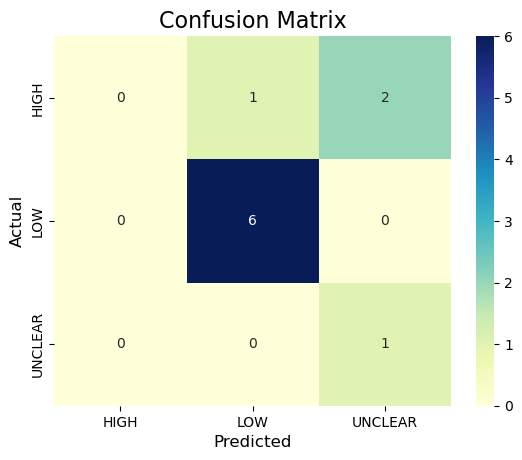

In [189]:
sns.heatmap(cm, annot=True,fmt='d', cmap='YlGnBu' , xticklabels=ticks, yticklabels=ticks)
plt.xlabel('Predicted', fontsize=12)
plt.ylabel('Actual', fontsize=12)
plt.title('Confusion Matrix',fontsize=16)
plt.show()

Get metrics. Accuracy should be the same as micro-F1 score. 

In [191]:
# Accuracy
accuracy = accuracy_score(df_llama_eval['label'], df_llama_eval['classification'])
print(accuracy)

# Precision
precision = precision_score(df_llama_eval['label'], df_llama_eval['classification'], average=None)
print(precision)

# Recall
recall = recall_score(df_llama_eval['label'], df_llama_eval['classification'], average=None)
print(recall)

# F1 score
f1 = f1_score(df_llama_eval['label'], df_llama_eval['classification'], average=None)
print(f1)

0.7
[0.         0.85714286 0.33333333]
[0. 1. 1.]
[0.         0.92307692 0.5       ]


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Get macro metrics.

In [193]:
# Precision
macro_precision = precision_score(df_llama_eval['label'], df_llama_eval['classification'], average='macro')
print(macro_precision, np.mean(precision))  # quick check that it's the same as the average over

# Recall
macro_recall = recall_score(df_llama_eval['label'], df_llama_eval['classification'], average='macro')
print(macro_recall)

# F1 score
macro_f1 = f1_score(df_llama_eval['label'], df_llama_eval['classification'], average='macro')
print(macro_f1)

0.3968253968253968 0.3968253968253968
0.6666666666666666
0.4743589743589744


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Get micro metrics. **NOTE: they are all the same because it's the same as accuracy.**

In [195]:
# Precision
micro_precision = precision_score(df_llama_eval['label'], df_llama_eval['classification'], average='micro')
print(micro_precision) 

# Recall
micro_recall = recall_score(df_llama_eval['label'], df_llama_eval['classification'], average='micro')
print(micro_recall)

# F1 score
micro_f1 = f1_score(df_llama_eval['label'], df_llama_eval['classification'], average='micro')
print(micro_f1, accuracy) # double check same as accuracy

0.7
0.7
0.7 0.7


Get weighted metrics. 

In [197]:
# Precision
w_precision = precision_score(df_llama_eval['label'], df_llama_eval['classification'], average='weighted')
print(w_precision) 

# Recall
w_recall = recall_score(df_llama_eval['label'], df_llama_eval['classification'], average='weighted')
print(w_recall)

# F1 score
w_f1 = f1_score(df_llama_eval['label'], df_llama_eval['classification'], average='weighted')
print(w_f1)

0.5476190476190476
0.7
0.6038461538461538


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Classification report.

In [199]:
cr = classification_report(df_llama_eval['label'], df_llama_eval['classification']) #, target_names = ticks)
print(cr)

              precision    recall  f1-score   support

        HIGH       0.00      0.00      0.00         3
         LOW       0.86      1.00      0.92         6
     UNCLEAR       0.33      1.00      0.50         1

    accuracy                           0.70        10
   macro avg       0.40      0.67      0.47        10
weighted avg       0.55      0.70      0.60        10



/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Get confusion matrix and classification report for gemma. 

In [201]:
cm2 = confusion_matrix(df_gemma_eval['label'], df_gemma_eval['classification'])
cm2

array([[3, 0, 0],
       [5, 1, 0],
       [0, 1, 0]])

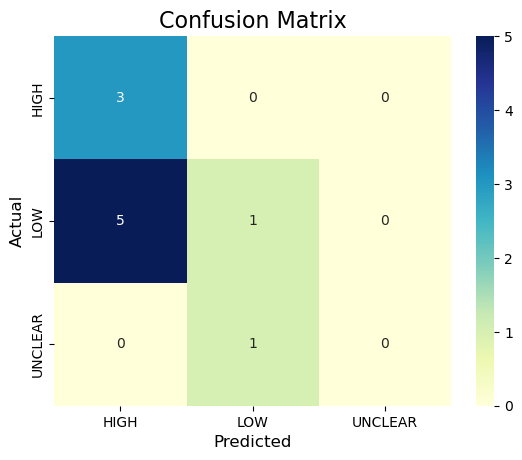

In [202]:
sns.heatmap(cm2, annot=True,fmt='d', cmap='YlGnBu' , xticklabels=ticks, yticklabels=ticks)
plt.xlabel('Predicted', fontsize=12)
plt.ylabel('Actual', fontsize=12)
plt.title('Confusion Matrix',fontsize=16)
plt.show()

In [203]:
cr2 = classification_report(df_gemma_eval['label'], df_gemma_eval['classification']) #, target_names = ticks)
print(cr2)

              precision    recall  f1-score   support

        HIGH       0.38      1.00      0.55         3
         LOW       0.50      0.17      0.25         6
     UNCLEAR       0.00      0.00      0.00         1

    accuracy                           0.40        10
   macro avg       0.29      0.39      0.27        10
weighted avg       0.41      0.40      0.31        10



/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### Must try ordinal metrics

First, convert to numeric.

In [206]:
mapping = {"LOW": 0, "UNCLEAR": 1, "HIGH": 2}

In [207]:
df_llama_eval['num_label'] = df_llama_eval['label'].map(mapping)
df_llama_eval['num_classification'] = df_llama_eval['classification'].map(mapping)

In [208]:
mae = mean_absolute_error(df_llama_eval['num_label'], df_llama_eval['num_classification'])
print(mae)
mse = mean_squared_error(df_llama_eval['num_label'], df_llama_eval['num_classification'])
print(mse)

0.4
0.6


In [209]:
kappa_quadratic = cohen_kappa_score(df_llama_eval['num_label'], df_llama_eval['num_classification'], weights='quadratic')
print(kappa_quadratic)

0.4915254237288136


And now for Gemma. 

In [211]:
df_gemma_eval['num_label'] = df_gemma_eval['label'].map(mapping)
df_gemma_eval['num_classification'] = df_gemma_eval['classification'].map(mapping)

Metrics

In [213]:
mae2 = mean_absolute_error(df_gemma_eval['num_label'], df_gemma_eval['num_classification'])
print(mae2)
mse2 = mean_squared_error(df_gemma_eval['num_label'], df_gemma_eval['num_classification'])
print(mse2)

1.1
2.1


In [214]:
kappa_quadratic2 = cohen_kappa_score(df_gemma_eval['num_label'], df_gemma_eval['num_classification'], weights='quadratic')
print(kappa_quadratic2)

0.07079646017699126


# Try few shot LLMs

Inspired by Suster et al. (2024), for every user prompt, we provide a random combo of justification and label for each class.

In [217]:
pd.unique(df_final['label'])

array(['LOW', 'UNCLEAR', 'HIGH'], dtype=object)

In [218]:
df_low = df_final[df_final['label'] == 'LOW']
print(len(df_low))
df_unclear = df_final[df_final['label'] == 'UNCLEAR']
print(len(df_unclear))
df_high = df_final[df_final['label'] == 'HIGH']
print(len(df_high))

6887
1520
1141


Pick a random of each. 

In [220]:
few_shot = (
    f"{df_low.sample(n=1)['label'].iloc[0]}: {df_low.sample(n=1)['answers_text'].iloc[0]}\n"
    f"{df_unclear.sample(n=1)['label'].iloc[0]}: {df_unclear.sample(n=1)['answers_text'].iloc[0]}\n"
    f"{df_high.sample(n=1)['label'].iloc[0]}: {df_high.sample(n=1)['answers_text'].iloc[0]}"
)
print(few_shot)

LOW: assignment to treatment or control group was by opening a sequen- tially numbered, sealed envelope containing the decision.
UNCLEAR: adaptive randomization (minimization)14 was used to stratify the groups on gender, race, history of depression, and baseline smoking rate.
HIGH: as this study focuses on brain changes through psychotherapy rather than examining the clinical efficacy of the treatment, we restricted all analyses to the sample of study completers.


In [221]:
system_prompt2 = (
    "You are an expert systematic reviewer trained in the Cochrane Risk of Bias (RoB1) tool." 
    " You will be provided with a question corresponding to a specific RoB1 item along with an excerpt containing the relevant information from the full-text article (i.e., context)."
    " You will also be provided with examples of correct classifications and justifications."
    " Return your answer *only* as Python dictionary with the following keys: 'classification', 'annotation', and 'justification'."
    " The classification must be one of ['LOW', 'HIGH', 'UNCLEAR']."
    " The annotation must include a direct quote from the context."
    " The justification must explain why the annotation supports the classification."
)
print(system_prompt2)

You are an expert systematic reviewer trained in the Cochrane Risk of Bias (RoB1) tool. You will be provided with a question corresponding to a specific RoB1 item along with an excerpt containing the relevant information from the full-text article (i.e., context). You will also be provided with examples of correct classifications and justifications. Return your answer *only* as Python dictionary with the following keys: 'classification', 'annotation', and 'justification'. The classification must be one of ['LOW', 'HIGH', 'UNCLEAR']. The annotation must include a direct quote from the context. The justification must explain why the annotation supports the classification.


In [222]:
user_prompt = (
    f"Question: {df_sample['question'].iloc[0]}"
    f"\n\nContext: {df_sample['context'].iloc[0]}"
    f"\n\nExamples:\n{few_shot}"
)
print(user_prompt)

Question: Was the allocation sequence random?

Context: exclusion criteria were: non-compliance with the protocol, enrolment in another clinical trial during the test period, pregnant (or planning to be) or nursing women, known allergy to one of the ingredients of both products, patients suffering from serious or progressive diseases (uncontrolled diabetes, peripheral circulatory disease, hiv, psoriasis, lichen planus, immunosuppressive disorders), and patients with other skin diseases in the studied zone. sample size, informed consent, randomization, and baseline data  based on previous available clinical data, a sample size of 100 subjects was calculated to allow correct statistical comparison between the test product and reference. based on this information, 102 eligible subjects were recruited by the study staff and randomly allocated to two groups. prior to the study, a randomization list was calculated by an external statistician using sas software (version 9.4). for this purpose

Let's try one with Lllama. **This does not work**

In [224]:
response = ollama.chat(
    model='llama3.2:3b'
    , messages=[
                {
            'role': 'system'
            , 'content': system_prompt2
        },
    {
        'role': 'user'
        , 'content': user_prompt
        }

    ]
    , options={'temperature': 0}
)
raw=response['message']['content']
print(raw)

```python
{
    'classification': 'LOW',
    'annotation': "assignment to treatment or control group was by opening a sequentially numbered, sealed envelope containing the decision.",
    'justification': "This quote directly supports the classification as LOW because it describes a simple, non-adaptive method of randomization where each participant is assigned to a group based on a sequentially numbered envelope. This is a clear example of a low-risk allocation sequence."
}
```


# Create functions to run analysis 

### LLM function.

In [227]:
def run_LLM(LLM_name, temperature, sample_size):

    df_sample = df_final.sample(n=sample_size)
    
    df_LLM = pd.DataFrame()
    start_time = time.time()
    
    for i, (_, row) in enumerate(df_sample.iterrows(), 1):
    
        loop_start = time.time()
        
        user_prompt = (
            f"Question: {row['question']}"
            f"\n\nContext: {row['context']}"
        )
        response = ollama.chat(
            model= LLM_name
            , messages=[
                        {
                    'role': 'system'
                    , 'content': system_prompt
                },
            {
                'role': 'user'
                , 'content': user_prompt
                }
        
            ]
            , options={'temperature': temperature}
        )
        raw=response['message']['content']
        cleaned = re.sub(r"^```[a-zA-Z]*", "", raw)
        cleaned = re.sub(r"```$", "", cleaned).strip()
    
        try:
            my_dict = ast.literal_eval(cleaned)
            df1 = pd.DataFrame([{'id': row['id'], 'question':row['question'], 'context':row['context']}])
            df2 = pd.DataFrame([my_dict])
            df_temp = pd.concat([df1,df2],axis=1)
            df_LLM = pd.concat([df_LLM, df_temp],axis=0)
        except (SyntaxError, ValueError) as e:
            print(f"Skipping ID={row['id']} due to parse error: {e}")
            continue
    
        loop_end = time.time()
        elapsed = loop_end - start_time
        loop_duration = loop_end - loop_start
        print(f"[{i}/{len(df_sample)}] Done ID={row['id']} in {loop_duration:.2f}s (Total elapsed: {elapsed/60:.1f} min)")

    df_LLM.to_csv(f"{LLM_name}_{temperature}_{sample_size}.csv", index=False)
    return(df_LLM)

Try function

In [229]:
llama_0 = run_LLM('llama3.2:3b', 0, 10)

[1/10] Done ID=661811223c6e44b26b18d8ca in 3.72s (Total elapsed: 0.1 min)
[2/10] Done ID=661811223c6e44b26b18dac2 in 4.82s (Total elapsed: 0.1 min)
[3/10] Done ID=661811223c6e44b26b18f32c in 6.33s (Total elapsed: 0.2 min)
[4/10] Done ID=6682e732cb7deacf322d46f9 in 5.73s (Total elapsed: 0.3 min)
[5/10] Done ID=661811223c6e44b26b18eb50 in 4.80s (Total elapsed: 0.4 min)
[6/10] Done ID=661811223c6e44b26b18cfb8 in 3.97s (Total elapsed: 0.5 min)
[7/10] Done ID=6682e732cb7deacf322d4add in 4.10s (Total elapsed: 0.6 min)
[8/10] Done ID=661811233c6e44b26b190ae1 in 3.68s (Total elapsed: 0.6 min)
[9/10] Done ID=661811223c6e44b26b18ddc6 in 3.80s (Total elapsed: 0.7 min)
[10/10] Done ID=661811223c6e44b26b18d9c2 in 3.78s (Total elapsed: 0.7 min)


In [230]:
llama_0_eval = pd.merge(df_final, llama_0, on='id')
# llama_0_eval.to_csv('llama_0_eval.csv', index=False)
llama_0_eval

,id,review,study,question_x,context_x,label,bias,bias_id,filename,line,context_tokens,answer_tokens,answers_text,answers_start,question_y,context_y,classification,annotation,justification
0,661811223c6e44b26b18f32c,CD000398,STD-ENOS-2015,"Were the trial participants, staff, and study ...",glyceryl trinitrate was sourced locally from s...,UNCLEAR,Blinding of participants and personnel (perfor...,QIT-07,PMC4343308.txt,167,260,28,"first, glyceryl trinitrate was given in a sing...",347,"Were the trial participants, staff, and study ...",glyceryl trinitrate was sourced locally from s...,LOW,Although patient-blinding was obtained with a ...,The annotation suggests that some level of bli...
1,6682e732cb7deacf322d46f9,CD001292,STD-Williams-2010,Incomplete outcome data addressed?,3.2. abstinence outcomes in smokers with schiz...,LOW,Incomplete outcome data (attrition bias),QIT-04,PMC2859987.txt,131,348,39,the follow-up rate was 87.4% (n=76) at 6 month...,674,Incomplete outcome data addressed?,3.2. abstinence outcomes in smokers with schiz...,LOW,"The authors state that ""the follow-up rate was...",The classification is LOW because the text men...
2,6682e732cb7deacf322d4add,CD005978,STD-Luabeya-2007,Incomplete outcome data addressed?,to determine the effect size for the primary o...,LOW,Incomplete outcome data (attrition bias),QIT-04,PMC1891438.txt,114,307,39,thirty-seven children withdrew and one died be...,886,Incomplete outcome data addressed?,to determine the effect size for the primary o...,LOW,We also tested for any bias in assignment to t...,The annotation supports a LOW classification b...
3,661811223c6e44b26b18cfb8,CD008524,STD-Daulaire-1992,Was the allocation sequence random?,"; xerophthalmia among infants was 1-5%, which ...",LOW,Random sequence generation (selection bias),QIT-01,PMC1881470.txt,26,210,20,we randomly selected by card eight of the 16 s...,387,Was the allocation sequence random?,"; xerophthalmia among infants was 1-5%, which ...",UNCLEAR,we randomly selected by card eight of the 16 s...,The annotation suggests that the selection was...
4,661811223c6e44b26b18eb50,CD011612,STD-Fava-2018,Was the allocation sequence concealed until pa...,"in this study, we aimed to assess the extent t...",LOW,Allocation concealment (selection bias),QIT-02,PMC6447473.txt,44,445,161,following a washout period for patients on pro...,685,Was the allocation sequence concealed until pa...,"in this study, we aimed to assess the extent t...",LOW,"""...patients were block randomized into each a...",The allocation sequence was not concealed unti...
5,661811223c6e44b26b18d8ca,CD012691,STD-Savoye-2007,Was the allocation sequence random?,the yale human investigation committee approve...,LOW,Random sequence generation (selection bias),QIT-01,PMC3898759.txt,34,183,17,randomization sequence was maintained by the s...,398,Was the allocation sequence random?,the yale human investigation committee approve...,LOW,Randomization sequence was maintained by the s...,The annotation supports a LOW classification b...
6,661811223c6e44b26b18d9c2,CD012932,STD-Graham-2018,Was the allocation sequence random?,enrollment was automated using a web-based cli...,LOW,Random sequence generation (selection bias),QIT-01,PMC6037305.txt,66,180,16,within-strata randomization assignments were a...,350,Was the allocation sequence random?,enrollment was automated using a web-based cli...,LOW,Within-strata randomization assignments were a...,The use of a computer algorithm for within-str...
7,661811223c6e44b26b18dac2,CD013162,STD-Ginsburg-2012,Was the allocation sequence random?,all evaluations (using the measures described ...,LOW,Random sequence generation (selection bias),QIT-01,PMC3373959.txt,169,136,25,randomization was conducted using the website ...,342,Was the allocation sequence random?,all evaluations (using the measures described ...,LOW,"The text states that ""randomization was conduc...",This annotation supports a LOW classification ...
8,661811233c6e44b26b190ae1,CD

In [231]:
gemma_0 = run_LLM('gemma3:1b', 0, 10)

[1/10] Done ID=661811223c6e44b26b18f3d6 in 4.65s (Total elapsed: 0.1 min)
[2/10] Done ID=661811223c6e44b26b18f243 in 2.75s (Total elapsed: 0.1 min)
[3/10] Done ID=661811223c6e44b26b18f4d6 in 2.34s (Total elapsed: 0.2 min)
[4/10] Done ID=661811223c6e44b26b18fa9f in 2.67s (Total elapsed: 0.2 min)
[5/10] Done ID=661811223c6e44b26b18fb8c in 2.80s (Total elapsed: 0.3 min)
[6/10] Done ID=661811223c6e44b26b18f01a in 2.38s (Total elapsed: 0.3 min)
[7/10] Done ID=661811223c6e44b26b18c6d1 in 3.15s (Total elapsed: 0.3 min)
[8/10] Done ID=661811223c6e44b26b18ee48 in 2.99s (Total elapsed: 0.4 min)
[9/10] Done ID=661811223c6e44b26b18cbbb in 3.61s (Total elapsed: 0.5 min)
[10/10] Done ID=661811223c6e44b26b18e5ee in 5.36s (Total elapsed: 0.5 min)


In [232]:
gemma_0_eval = pd.merge(df_final, gemma_0, on='id')
# gemma_0_eval.to_csv('gemma_0_eval.csv', index=False)
gemma_0_eval

,id,review,study,question_x,context_x,label,bias,bias_id,filename,line,context_tokens,answer_tokens,answers_text,answers_start,question_y,context_y,classification,annotation,justification
0,661811223c6e44b26b18c6d1,CD000978,STD-Hartmann-2001,Was the allocation sequence random?,"), gosen, berlin, 15537, germany 2 2001 84 3 3...",UNCLEAR,Random sequence generation (selection bias),QIT-01,PMC2363753.txt,5,423,52,40 patients with solid tumours were randomized...,1262,Was the allocation sequence random?,"), gosen, berlin, 15537, germany 2 2001 84 3 3...",HIGH,The article details a pilot study evaluating t...,The context explicitly states that the article...
1,661811223c6e44b26b18f3d6,CD001841,STD-Barraclough-1973,"Were the trial participants, staff, and study ...",the untreated control group received calcium l...,HIGH,Blinding of participants and personnel (perfor...,QIT-07,PMC1586420.txt,32,241,25,progression from one regimen to the next depen...,404,"Were the trial participants, staff, and study ...",the untreated control group received calcium l...,HIGH,The context explicitly states that ‘the physic...,The passage highlights a crucial element of th...
2,661811223c6e44b26b18f4d6,CD003177,STD-MAPT-2017,Was the outcome assessor blinded to the interv...,the program includes a general advice componen...,LOW,Blinding of outcome assessment (detection bias),QIT-08,PMC4652787.txt,112,200,30,"blinding for supplementation, blinding is ensu...",556,Was the outcome assessor blinded to the interv...,the program includes a general advice componen...,HIGH,"‘owing to the nature of the intervention, part...",The text explicitly states that participants a...
3,661811223c6e44b26b18cbbb,CD005457,STD-Leung-2006,Was the allocation sequence random?,women with high risk factors for primary postp...,LOW,Random sequence generation (selection bias),QIT-01,PMC1804104.txt,32,259,28,"this was performed by opening a sealed, consec...",641,Was the allocation sequence random?,women with high risk factors for primary postp...,LOW,The context states that ‘women were randomised...,The text describes a randomized allocation of ...
4,661811223c6e44b26b18e5ee,CD008422,STD-Golan-2013,Was the allocation sequence concealed until pa...,participation after enrolment was terminated i...,HIGH,Allocation concealment (selection bias),QIT-02,PMC3691658.txt,37,259,17,the assignment to groups was randomly set in a...,743,Was the allocation sequence concealed until pa...,participation after enrolment was terminated i...,HIGH,The context explicitly states that the allocat...,"The text states, ""participation after enrolmen..."
5,661811223c6e44b26b18fa9f,CD008729,STD-Ferguson-2012,Was the outcome assessor blinded to the interv...,the decision to include individuals 18 months ...,LOW,Blinding of outcome assessment (detection bias),QIT-08,PMC3955296.txt,72,172,17,the research assistant completing all assessme...,512,Was the outcome assessor blinded to the interv...,the decision to include individuals 18 months ...,LOW,‘the research assistant completing all assessm...,The statement highlights a potential oversight...
6,661811223c6e44b26b18fb8c,CD009149,STD-Weiss-2015,Was the outcome assessor blinded to the interv...,to avoid a difference between intervention and...,LOW,Blinding of outcome assessment (detection bias),QIT-08,PMC4605204.txt,148,198,39,blinding baseline assessments were conducted b...,507,Was the outcome assessor blinded to the interv...,to avoid a difference between intervention and...,HIGH,The context explicitly states that 'cmhws trea...,The text highlights the crucial step of matchi...
7,661811223c6e44b26b18ee48,CD012859,STD-Ghosh-2011,Was the allocation sequence concealed until pa...,"[9] in this research work, we wanted to study ...",UNCLEAR,Allocation concealment (selection bias),QIT-02,PMC4173407.txt,25,332,25,the patients were randomly (computer-generated...,908,Was the allocation sequence concealed until pa...,"[9] in this research work, we wanted to study ...",H

### Data analysis function. 

Define function.

In [238]:
def analysis(df_eval):
    cr = classification_report(df_eval['label'], df_eval['classification']) #, target_names = ticks)
    print(cr)

    df_eval['num_label'] = df_eval['label'].map(mapping)
    df_eval['num_classification'] = df_eval['classification'].map(mapping)

    mae = mean_absolute_error(df_eval['num_label'], df_eval['num_classification'])
    print(f"Mean absolute error: {mae}")
    mse = mean_squared_error(df_eval['num_label'], df_eval['num_classification'])
    print(f"Mean squared error: {mse}")

    kappa_quadratic = cohen_kappa_score(df_eval['num_label'], df_eval['num_classification'], weights='quadratic')
    print(f"Kappa quadratic: {kappa_quadratic}")

    return()

Run on llama and gemma. 

In [240]:
analysis(llama_0_eval)
analysis(gemma_0_eval)

              precision    recall  f1-score   support

         LOW       0.78      0.88      0.82         8
     UNCLEAR       0.00      0.00      0.00         2

    accuracy                           0.70        10
   macro avg       0.39      0.44      0.41        10
weighted avg       0.62      0.70      0.66        10

Mean absolute error: 0.3
Mean squared error: 0.3
Kappa quadratic: -0.15384615384615374
              precision    recall  f1-score   support

        HIGH       0.25      1.00      0.40         2
         LOW       1.00      0.33      0.50         6
     UNCLEAR       0.00      0.00      0.00         2

    accuracy                           0.40        10
   macro avg       0.42      0.44      0.30        10
weighted avg       0.65      0.40      0.38        10

Mean absolute error: 1.0
Mean squared error: 1.8
Kappa quadratic: 0.21052631578947367


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


()